# 📚 Has the Importance of Education for Determining Income Increased Over Time?

## 🎯 Research Question

**Has the importance of education in predicting income increased over time, compared to other factors such as age, gender, or occupation?**

Understanding this helps assess the role of educational attainment in shaping economic outcomes, and whether its predictive power has evolved with structural changes in the labor market.

---

## 🧪 Objective

To build and compare several supervised regression models that predict income levels, and evaluate the relative contribution of **education** over time. I use data of 2000, 2010, 2015, and 2020. 

---

## 🧰 Methodology

We use the following machine learning models:

- **Linear Regression**  
- **Ridge Regression**  
- **Lasso Regression**  
- **Random Forest Regressor**  
- **Gradient Boosting Regressor**

These models are trained on a dataset containing individual-level variables, including:

- `ESCOLARIDAD_ACUMULADA` *(accumulated years of schooling / total years of education)*  
- `EDAD` *(age)*  
- `SEXO` *(gender)*  
- `RELIGION` *(religion)*  
- `ANIO` *(year of survey)*  
- And other socio-demographic features

Interaction terms like `ESCOLARIDAD_ACUMULADA × ANIO` are included to examine changes in the predictive role of education over time.

---

## 📌 Outputs

We compare model performance using:

- ✅ Cross-validated **Mean Squared Error (MSE)** and **Variance**
- ✅ Number of non-zero coefficients (for sparse models like Lasso)
- ✅ Feature importance via **model coefficients** and **SHAP values**
- ✅ A final comparison table summarizing performance
- ✅ Visualizations of top predictors across models

---

## Filtering of Data

In [89]:
# ===============================
# 📚 IMPORT LIBRARIES
# ===============================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ===============================
# 📁 LOAD DATASET
# ===============================
# Define the project directory and path to the cleaned dataset
project_dir = os.path.dirname(os.getcwd())
data_path = os.path.join(project_dir, "cleandata", "combined_personas_sample.csv")

# Read the CSV into a pandas DataFrame
df = pd.read_csv(
    data_path,
    low_memory=False,                          # Prevents dtype inference warnings
    na_values=["NaN", "NA", "N/A", "", " "],   # Define common NA representations
    dtype={"UPM": str}                         # Ensure UPM is treated as a string
)

# Avoid scientific notation in pandas output
pd.set_option('display.float_format', '{:.4f}'.format)

# Display basic info about the dataset (number of rows, columns, dtypes, etc.)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   ANIO                                  72000 non-null  int64  
 1   ID_PERSONA                            72000 non-null  object 
 2   LLAVE_ENTIDAD                         72000 non-null  int64  
 3   LLAVE_MUNICIPIO                       72000 non-null  int64  
 4   CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)  72000 non-null  int64  
 5   LLAVE_LOCALIDAD                       72000 non-null  int64  
 6   CLAVE_LOCALIDAD_INEGI                 21039 non-null  float64
 7   ID_VIVIENDA                           72000 non-null  int64  
 8   ID_HOGAR                              16000 non-null  float64
 9   LLAVE_COBERTURA                       72000 non-null  int64  
 10  LLAVE_CLASEVIVIENDA                   72000 non-null  int64  
 11  LLAVE_SEXO     

In [2]:
# ===============================
# 🧹 VARIABLE TYPE ASSIGNMENT
# ===============================

# 1. 📈 Define continuous (numerical) variables manually
continuous_vars = [
    'INGRESO', 'HORAS_TRABAJADAS', 'ESCOLARIDAD_ACUMULADA', 'ESCOLARIDAD', 'EDAD',
    'HIJOS_NACIDOS', 'HIJOS_VIVOS', 'HIJOS_FALLECIDOS'
]

# 2. 🏷️ Define categorical variables manually
categorical_vars = [
    'ANIO', 'LLAVE_SEXO', 'LLAVE_PARENTESCO', 'LLAVE_IDENTMADRE', 'LLAVE_IDENTPADRE',
    'LLAVE_PAIS_NAC', 'LLAVE_ENTIDAD_NAC', 'LLAVE_NACIONALIDAD', 'LLAVE_SERSALUD',
    'LLAVE_AFRODES', 'LLAVE_REGISNAC', 'LLAVE_RELIGION', 'LLAVE_HLENGUA',
    'LLAVE_LENGUAMAT', 'LLAVE_HESPANOL', 'LLAVE_ELENGUA', 'LLAVE_PERTEINDIGENA',
    'LLAVE_ASISESCOLAR', 'LLAVE_PAIS_ASISESCOLAR', 'LLAVE_ENTIDAD_ASISESCOLAR',
    'LLAVE_MUNICIPIO_ASISESCOLAR', 'LLAVE_TIETRASLADO_ESCOLAR',
    'LLAVE_MEDTRASLADO_ESCOLAR', 'LLAVE_NIVACAD', 'LLAVE_CARRERA',
    'LLAVE_ALFABETISMO', 'LLAVE_PAIS_RES5A', 'LLAVE_ENTIDAD_RES5A',
    'LLAVE_MUNICIPIO_RES5A', 'LLAVE_CAUSAMIGRACION', 'LLAVE_SITUACONYUGAL',
    'LLAVE_IDENTPAREJA', 'LLAVE_ACTPRIMARIA', 'LLAVE_OCUPACION', 'LLAVE_SITTRA',
    'LLAVE_ACTECONOMICA', 'ACTIVIDAD_ECONOMICA_INEGI', 'LLAVE_PAIS_TRABAJO',
    'LLAVE_ENTIDAD_TRABAJO', 'LLAVE_MUNICIPIO_TRABAJO',
    'LLAVE_TIETRASLADO_TRABAJO', 'LLAVE_MEDTRASLADO_TRABAJO',
    'LLAVE_TAMLOC', 'ESTRATO', 'UPM', 'MERCADO_TRABAJO_LOCAL'
]

# ===============================
# 🔄 VARIABLE TYPE CONVERSION
# ===============================

# Convert selected columns to categorical type
for col in categorical_vars:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Convert selected columns to numeric (float), coercing errors
for col in continuous_vars:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# ✅ Display updated structure of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72000 entries, 0 to 71999
Data columns (total 66 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   ANIO                                  72000 non-null  category
 1   ID_PERSONA                            72000 non-null  object  
 2   LLAVE_ENTIDAD                         72000 non-null  int64   
 3   LLAVE_MUNICIPIO                       72000 non-null  int64   
 4   CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)  72000 non-null  int64   
 5   LLAVE_LOCALIDAD                       72000 non-null  int64   
 6   CLAVE_LOCALIDAD_INEGI                 21039 non-null  float64 
 7   ID_VIVIENDA                           72000 non-null  int64   
 8   ID_HOGAR                              16000 non-null  float64 
 9   LLAVE_COBERTURA                       72000 non-null  int64   
 10  LLAVE_CLASEVIVIENDA                   72000 non-null  int64   
 11  LL

In [3]:
# ===============================
# 📊 NULL VALUE INSPECTION
# ===============================

# 1. Calculate the percentage of null values per column
null_percentage = np.round(100 - df.notnull().mean() * 100)

# 2. Create a DataFrame to organize results
null_summary = pd.DataFrame(null_percentage, columns=["Percentage of Null Values"])

# 3. Display the full summary
print(null_summary.to_string())

                                      Percentage of Null Values
ANIO                                                        0.0
ID_PERSONA                                                  0.0
LLAVE_ENTIDAD                                               0.0
LLAVE_MUNICIPIO                                             0.0
CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)                        0.0
LLAVE_LOCALIDAD                                             0.0
CLAVE_LOCALIDAD_INEGI                                      71.0
ID_VIVIENDA                                                 0.0
ID_HOGAR                                                   78.0
LLAVE_COBERTURA                                             0.0
LLAVE_CLASEVIVIENDA                                         0.0
LLAVE_SEXO                                                  0.0
LLAVE_PARENTESCO                                            0.0
LLAVE_IDENTMADRE                                            0.0
LLAVE_IDENTPADRE                        

🧹 Handling Missing Data

To ensure the quality of our regression models, we remove variables with a high percentage of missing values. However, since education is a central variable in our analysis, we adjust the threshold for filtering.

⚙️ Filtering Rule:
- Remove columns with more than 10% missing values.
- This threshold is a relaxed version of the more conservative 5% typically used.
- The goal is to preserve key variables (especially education-related ones) while still reducing noise and data sparsity.

🔍 Why this matters:

Removing columns with excessive missing data helps prevent:
- Model bias from uneven imputation
- Overfitting due to sparse feature space
- Unstable coefficient estimates

We later apply imputation strategies (e.g., median for numeric values and most frequent for categorical variables) during preprocessing to handle the remaining missing values.


In [4]:
# ✅ Filter columns based on missing value threshold
missing_percentage = df.isnull().mean() * 100
columns_to_keep = missing_percentage[missing_percentage <= 10].index
df_filtered = df[columns_to_keep]

# 📊 Recalculate the null percentages after filtering
null_percentage = np.round(100 - df_filtered.notnull().mean() * 100)
non_null_percentage_df = pd.DataFrame(null_percentage, columns=['Percentage of Null Values'])
print(non_null_percentage_df)

# Count the number of remaining rows
remaining_cols = df_filtered.shape[1]

# Print the number of remaining rows
print("Number of remaining columns after removing those with >10% missing values:", remaining_cols)

                                      Percentage of Null Values
ANIO                                                        0.0
ID_PERSONA                                                  0.0
LLAVE_ENTIDAD                                               0.0
LLAVE_MUNICIPIO                                             0.0
CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)                        0.0
LLAVE_LOCALIDAD                                             0.0
ID_VIVIENDA                                                 0.0
LLAVE_COBERTURA                                             0.0
LLAVE_CLASEVIVIENDA                                         0.0
LLAVE_SEXO                                                  0.0
LLAVE_PARENTESCO                                            0.0
LLAVE_IDENTMADRE                                            0.0
LLAVE_IDENTPADRE                                            0.0
LLAVE_PAIS_NAC                                              0.0
LLAVE_ENTIDAD_NAC                       

After filtering out columns with too much missingness, we proceed to remove rows that still contain missing values in the remaining features.

In [5]:
# 🧹 Drop all rows with any remaining missing values
df_cleaned = df_filtered.dropna()

# 📏 Show how much data is left
remaining_rows = df_cleaned.shape[0]
print("Number of remaining rows after removing rows with missing values:", remaining_rows)

Number of remaining rows after removing rows with missing values: 65861


📊 Overview of the Cleaned Dataset

Once missing values are handled, we explore the structure and distribution of the remaining variables using df.info() and df.describe().

These steps give us a first idea of:
- Which variables are numeric or categorical
- Their basic distribution: means, min/max, standard deviations
- Whether further preprocessing (scaling, encoding) is needed before modeling

In [6]:
# Display information about the remaining columns
df_cleaned.info()

# Display descriptive statistics for the remaining columns
df_cleaned.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 65861 entries, 0 to 71999
Data columns (total 58 columns):
 #   Column                                Non-Null Count  Dtype   
---  ------                                --------------  -----   
 0   ANIO                                  65861 non-null  category
 1   ID_PERSONA                            65861 non-null  object  
 2   LLAVE_ENTIDAD                         65861 non-null  int64   
 3   LLAVE_MUNICIPIO                       65861 non-null  int64   
 4   CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)  65861 non-null  int64   
 5   LLAVE_LOCALIDAD                       65861 non-null  int64   
 6   ID_VIVIENDA                           65861 non-null  int64   
 7   LLAVE_COBERTURA                       65861 non-null  int64   
 8   LLAVE_CLASEVIVIENDA                   65861 non-null  int64   
 9   LLAVE_SEXO                            65861 non-null  category
 10  LLAVE_PARENTESCO                      65861 non-null  category
 11  LL

,LLAVE_ENTIDAD,LLAVE_MUNICIPIO,CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM),LLAVE_LOCALIDAD,ID_VIVIENDA,LLAVE_COBERTURA,LLAVE_CLASEVIVIENDA,FACTOR_EXP,EDAD,ESCOLARIDAD,ESCOLARIDAD_ACUMULADA,INGRESO
count,65861.000000,65861.000000,65861.000000,6.586100e+04,6.586100e+04,65861.000000,65861.000000,65861.000000,65861.000000,65861.000000,65861.000000,6.586100e+04
mean,17.728413,1077.098814,76.164969,2.610376e+06,2.012059e+15,1.030321,0.649975,7.904739,30.807640,2.982706,6.312552,7.632977e+03
std,7.885532,759.516520,99.566432,5.774933e+06,7.012302e+12,0.943294,1.090415,12.516898,20.411292,1.810090,4.669689,7.793284e+05
min,1.000000,1.000000,1.000000,0.000000e+00,2.000000e+15,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000e+00
25%,12.000000,403.000000,17.000000,0.000000e+00,2.010000e+15,0.000000,0.000000,2.000000,14.000000,2.000000,2.000000,0.000000e+00
50%,16.000000,894.000000,42.000000,0.000000e+00,2.015110e+15,1.000000,0.000000,4.000000,27.000000,3.000000,6.000000,0.000000e+00
75%,23.000000,1804.000000,95.000000,2.801390e+05,2.015302e+15,2.000000,1.000000,9.000000,44.000000,4.000000,9.000000,1.500000e+03
max,32.000000,2469.000000,570.000000,2.455004e+07,2.020321e+15,2.000000,10.000000,646.000000,110.000000,9.000000,24.000000,1.000000e+08


👷‍♀️ Restricting the Analysis to Adults Likely to Work Full-Time

Although the legal working age in Mexico begins at 15 years old, this analysis focuses on individuals aged 18 and older. The reason for this is that people under 18 are less likely to:
- Participate in the labor market on a full-time basis
- Have completed their basic education
- Earn stable or comparable income across time

In [7]:
# Filter individuals aged 18 or older
df_cleaned_w_age = df_cleaned[df_cleaned['EDAD'] >= 18].copy()

# Optional: check the shape
print(f"✅ Working-age dataset shape: {df_cleaned_w_age.shape}")

✅ Working-age dataset shape: (43943, 58)


💰 Transforming the Income Variable

The original income variable (INGRESO) shows a high degree of skewness and dispersion, with a long right tail of high earners. This can distort the performance and interpretation of regression models, especially those assuming normally distributed errors.

To address this, we apply a logarithmic transformation:

In [8]:
df_cleaned_w_age['LOG_INGRESO'] = np.log1p(df_cleaned_w_age['INGRESO'])  # computes ln(1 + ingreso)

This transformation has several benefits:
- 📉 Reduces the impact of extreme income values (outliers)
- 🧮 Brings the distribution closer to normality
- ✅ Makes linear relationships easier to model

We visualize the effect below:

🔍 Distribution Before and After Transformation
- Left: Original income values
- Right: Log-transformed income values (ln(1 + INGRESO))


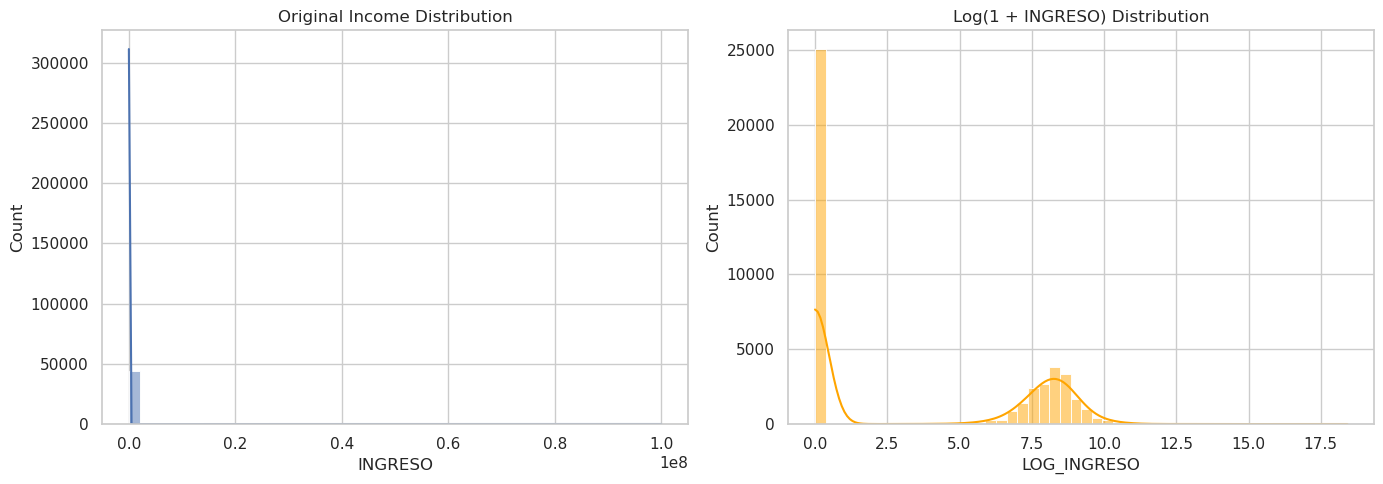

In [9]:
# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Original Income
sns.histplot(df_cleaned_w_age['INGRESO'], bins=50, ax=axs[0], kde=True)
axs[0].set_title("Original Income Distribution")
axs[0].set_xlabel("INGRESO")

# Log Income
sns.histplot(df_cleaned_w_age['LOG_INGRESO'], bins=50, ax=axs[1], kde=True, color='orange')
axs[1].set_title("Log(1 + INGRESO) Distribution")
axs[1].set_xlabel("LOG_INGRESO")

plt.tight_layout()
plt.show()

🧹 Filtering to Focus on Income Earners

After filtering to the working-age population, we further restrict our dataset to individuals with positive income.

This step ensures that our analysis reflects the income dynamics only among people who are earning. Including individuals with zero income (e.g., students, unemployed, or informal workers without reported earnings) would introduce biases and reduce the explanatory power of education-related variables.

Zero-income individuals often belong to structurally different subgroups:
- In school/training
- Outside the labor force
- Working informally and underreported
- Not seeking employment

These groups could be influenced by different factors than those determining wage levels.

We then compute the natural logarithm of income using log1p() to stabilize variance and normalize the distribution.

In [73]:
# Filter first
df_positive_income = df_cleaned_w_age[df_cleaned_w_age['INGRESO'] > 0].copy()

# Then compute the log
df_positive_income['LOG_INGRESO'] = np.log1p(df_positive_income['INGRESO'])

# 🖨️ Optional: Check result
print(df_positive_income[['INGRESO', 'LOG_INGRESO']].describe())

            INGRESO  LOG_INGRESO
count    18890.0000   18890.0000
mean     26477.1049       8.1559
std    1455029.4042       0.9159
min          2.0000       1.0986
25%       2143.0000       7.6704
50%       3857.0000       8.2579
75%       6000.0000       8.6997
max   99999999.0000      18.4207


🔍 Income Distribution Before and After Log Transformation

To address the strong right-skew in the income variable, we apply a log transformation to INGRESO and examine the difference in distribution:
- The left plot shows the original income distribution, where a majority of observations are concentrated near zero, with a long tail extending to very high values.
- The right plot displays the transformed distribution using log(1 + INGRESO). This transformation compresses extreme values and spreads out lower ones, making the data more symmetric and suitable for regression modeling.

We continue the analysis using the log-transformed income as the target variable: LOG_INGRESO.

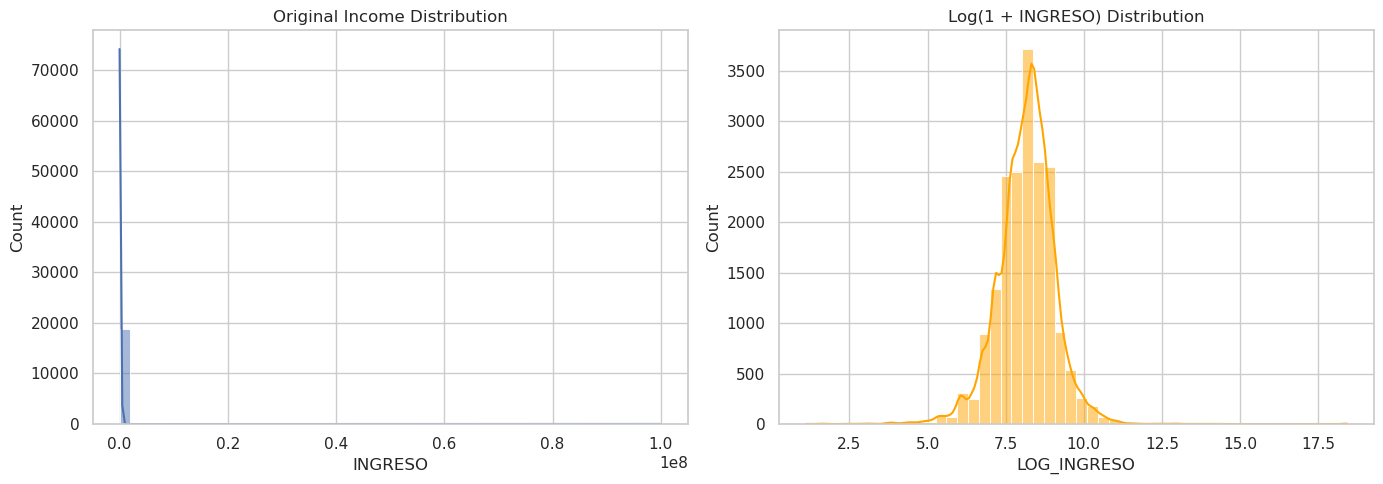

In [74]:
# Set style
sns.set(style="whitegrid")

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Original Income
sns.histplot(df_positive_income['INGRESO'], bins=50, ax=axs[0], kde=True)
axs[0].set_title("Original Income Distribution")
axs[0].set_xlabel("INGRESO")

# Log Income
sns.histplot(df_positive_income['LOG_INGRESO'], bins=50, ax=axs[1], kde=True, color='orange')
axs[1].set_title("Log(1 + INGRESO) Distribution")
axs[1].set_xlabel("LOG_INGRESO")

plt.tight_layout()
plt.show()

## Train-Test Split

To evaluate model performance fairly, we divide our dataset into training and testing subsets. This ensures that we train our models on one portion of the data and test their predictive ability on unseen examples.
	•	Training Set (90%): Used to train the model
	•	Testing Set (10%): Held out for evaluating out-of-sample performance

In [75]:
# Define the features (X) and target (y)
X = df_positive_income.drop(columns=['LOG_INGRESO'])
y = df_positive_income['LOG_INGRESO']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (17001, 58)
X_test shape: (1889, 58)
y_train shape: (17001,)
y_test shape: (1889,)


## Data Exploration

🔍 Data Exploration

Before modeling, we perform an initial exploration of the training dataset. This helps us understand:
- What types of variables we have (categorical vs. numerical)
- How variables like education, age, and income behave
- Whether any transformations or encodings will be needed

We begin by combining the training features and target variable into one dataset for easier inspection.

In [76]:
# Step 1: Concatenate X_train and y_train 
train_data = pd.concat([X_train, y_train], axis=1)
train_data.columns

Index(['ANIO', 'ID_PERSONA', 'LLAVE_ENTIDAD', 'LLAVE_MUNICIPIO',
       'CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)', 'LLAVE_LOCALIDAD',
       'ID_VIVIENDA', 'LLAVE_COBERTURA', 'LLAVE_CLASEVIVIENDA', 'LLAVE_SEXO',
       'LLAVE_PARENTESCO', 'LLAVE_IDENTMADRE', 'LLAVE_IDENTPADRE',
       'LLAVE_PAIS_NAC', 'LLAVE_ENTIDAD_NAC', 'LLAVE_NACIONALIDAD',
       'LLAVE_SERSALUD', 'LLAVE_AFRODES', 'LLAVE_REGISNAC', 'LLAVE_RELIGION',
       'LLAVE_HLENGUA', 'LLAVE_LENGUAMAT', 'LLAVE_HESPANOL', 'LLAVE_ELENGUA',
       'LLAVE_PERTEINDIGENA', 'LLAVE_ASISESCOLAR', 'LLAVE_PAIS_ASISESCOLAR',
       'LLAVE_ENTIDAD_ASISESCOLAR', 'LLAVE_MUNICIPIO_ASISESCOLAR',
       'LLAVE_TIETRASLADO_ESCOLAR', 'LLAVE_MEDTRASLADO_ESCOLAR',
       'LLAVE_NIVACAD', 'LLAVE_CARRERA', 'LLAVE_ALFABETISMO',
       'LLAVE_PAIS_RES5A', 'LLAVE_ENTIDAD_RES5A', 'LLAVE_MUNICIPIO_RES5A',
       'LLAVE_CAUSAMIGRACION', 'LLAVE_SITUACONYUGAL', 'LLAVE_IDENTPAREJA',
       'LLAVE_ACTPRIMARIA', 'LLAVE_OCUPACION', 'LLAVE_SITTRA',
       'LLAVE_AC

To prepare the data for modeling and visualization, we classify the variables into continuous and categorical types. This distinction will guide our preprocessing and help tailor our feature engineering steps later on.

We also enforce appropriate data types to ensure compatibility with scikit-learn pipelines and other libraries.

In [77]:
# 1) Setup
# Set style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

# 2) Define continuous variables
continuous_vars = [
    "EDAD", 
    "ESCOLARIDAD", 
    "ESCOLARIDAD_ACUMULADA", 
    "FACTOR_EXP", 
    "INGRESO",
    "LOG_INGRESO"
]

# 3) Define categorical variables as the remaining columns
all_columns = train_data.columns.tolist()
categorical_vars = list(set(all_columns) - set(continuous_vars))

# 4) Force types 
#train data
train_data[continuous_vars] = train_data[continuous_vars].astype(float)
train_data[categorical_vars] = train_data[categorical_vars].astype("category")

#test data
train_data[continuous_vars] = train_data[continuous_vars].astype(float)
train_data[categorical_vars] = train_data[categorical_vars].astype("category")

# 5) Done!
print("✅ Continuous Variables:", continuous_vars)
print("\n✅ Categorical Variables:", categorical_vars)

✅ Continuous Variables: ['EDAD', 'ESCOLARIDAD', 'ESCOLARIDAD_ACUMULADA', 'FACTOR_EXP', 'INGRESO', 'LOG_INGRESO']

✅ Categorical Variables: ['LLAVE_IDENTPADRE', 'LLAVE_NACIONALIDAD', 'LLAVE_PERTEINDIGENA', 'LLAVE_PAIS_RES5A', 'ANIO', 'LLAVE_ACTECONOMICA', 'LLAVE_ACTPRIMARIA', 'LLAVE_MUNICIPIO', 'LLAVE_ASISESCOLAR', 'LLAVE_AFRODES', 'LLAVE_MUNICIPIO_ASISESCOLAR', 'LLAVE_TIETRASLADO_ESCOLAR', 'UPM', 'LLAVE_PAIS_TRABAJO', 'LLAVE_MEDTRASLADO_TRABAJO', 'LLAVE_SEXO', 'LLAVE_LOCALIDAD', 'MERCADO_TRABAJO_LOCAL', 'LLAVE_ENTIDAD_TRABAJO', 'ID_VIVIENDA', 'LLAVE_MUNICIPIO_TRABAJO', 'LLAVE_COBERTURA', 'LLAVE_LENGUAMAT', 'LLAVE_ALFABETISMO', 'LLAVE_IDENTPAREJA', 'LLAVE_TIETRASLADO_TRABAJO', 'ESTRATO', 'ID_PERSONA', 'LLAVE_ENTIDAD_RES5A', 'CLAVE_MUNICIPIO_INEGI(CLAVE_DE_AGEM)', 'LLAVE_ENTIDAD', 'LLAVE_SITUACONYUGAL', 'LLAVE_CLASEVIVIENDA', 'LLAVE_IDENTMADRE', 'LLAVE_NIVACAD', 'LLAVE_ENTIDAD_NAC', 'LLAVE_CARRERA', 'LLAVE_REGISNAC', 'LLAVE_SITTRA', 'LLAVE_ELENGUA', 'LLAVE_SERSALUD', 'LLAVE_CAUSAMIGRACIO

📊 Visualizing Continuous Variables

To better understand the distribution and relationships between numeric features, we plot:
- Histograms with KDE curves for each variable
- A pairplot to observe potential correlations and non-linear patterns

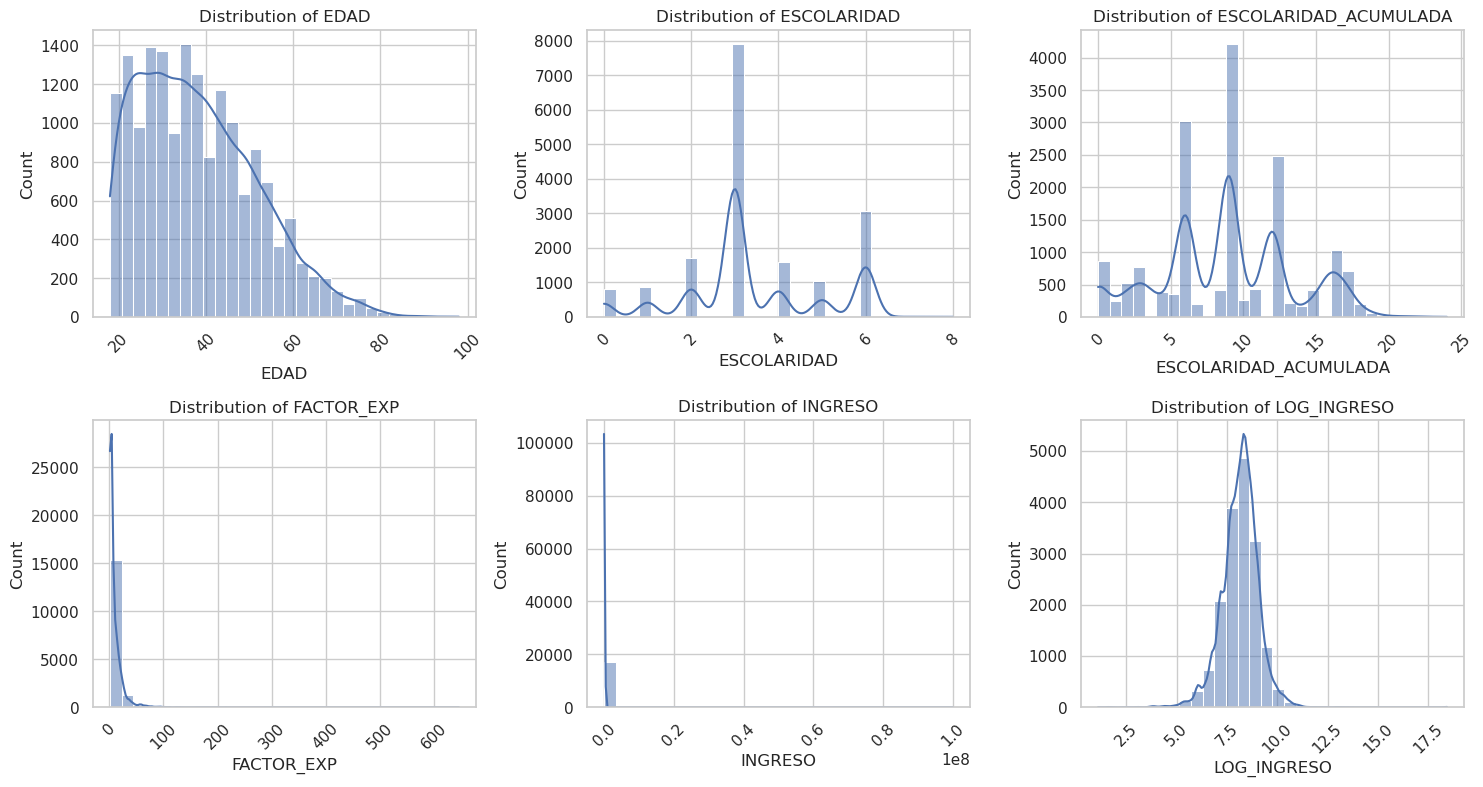

In [15]:
# 3) Plot Continuous Variables (Histograms)
n_cols = 3
n_rows = -(-len(continuous_vars) // n_cols)  # Ceiling division

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(continuous_vars):
    sns.histplot(data=train_data, x=col, ax=axs[i], kde=True, bins=30)
    axs[i].set_title(f"Distribution of {col}")
    axs[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

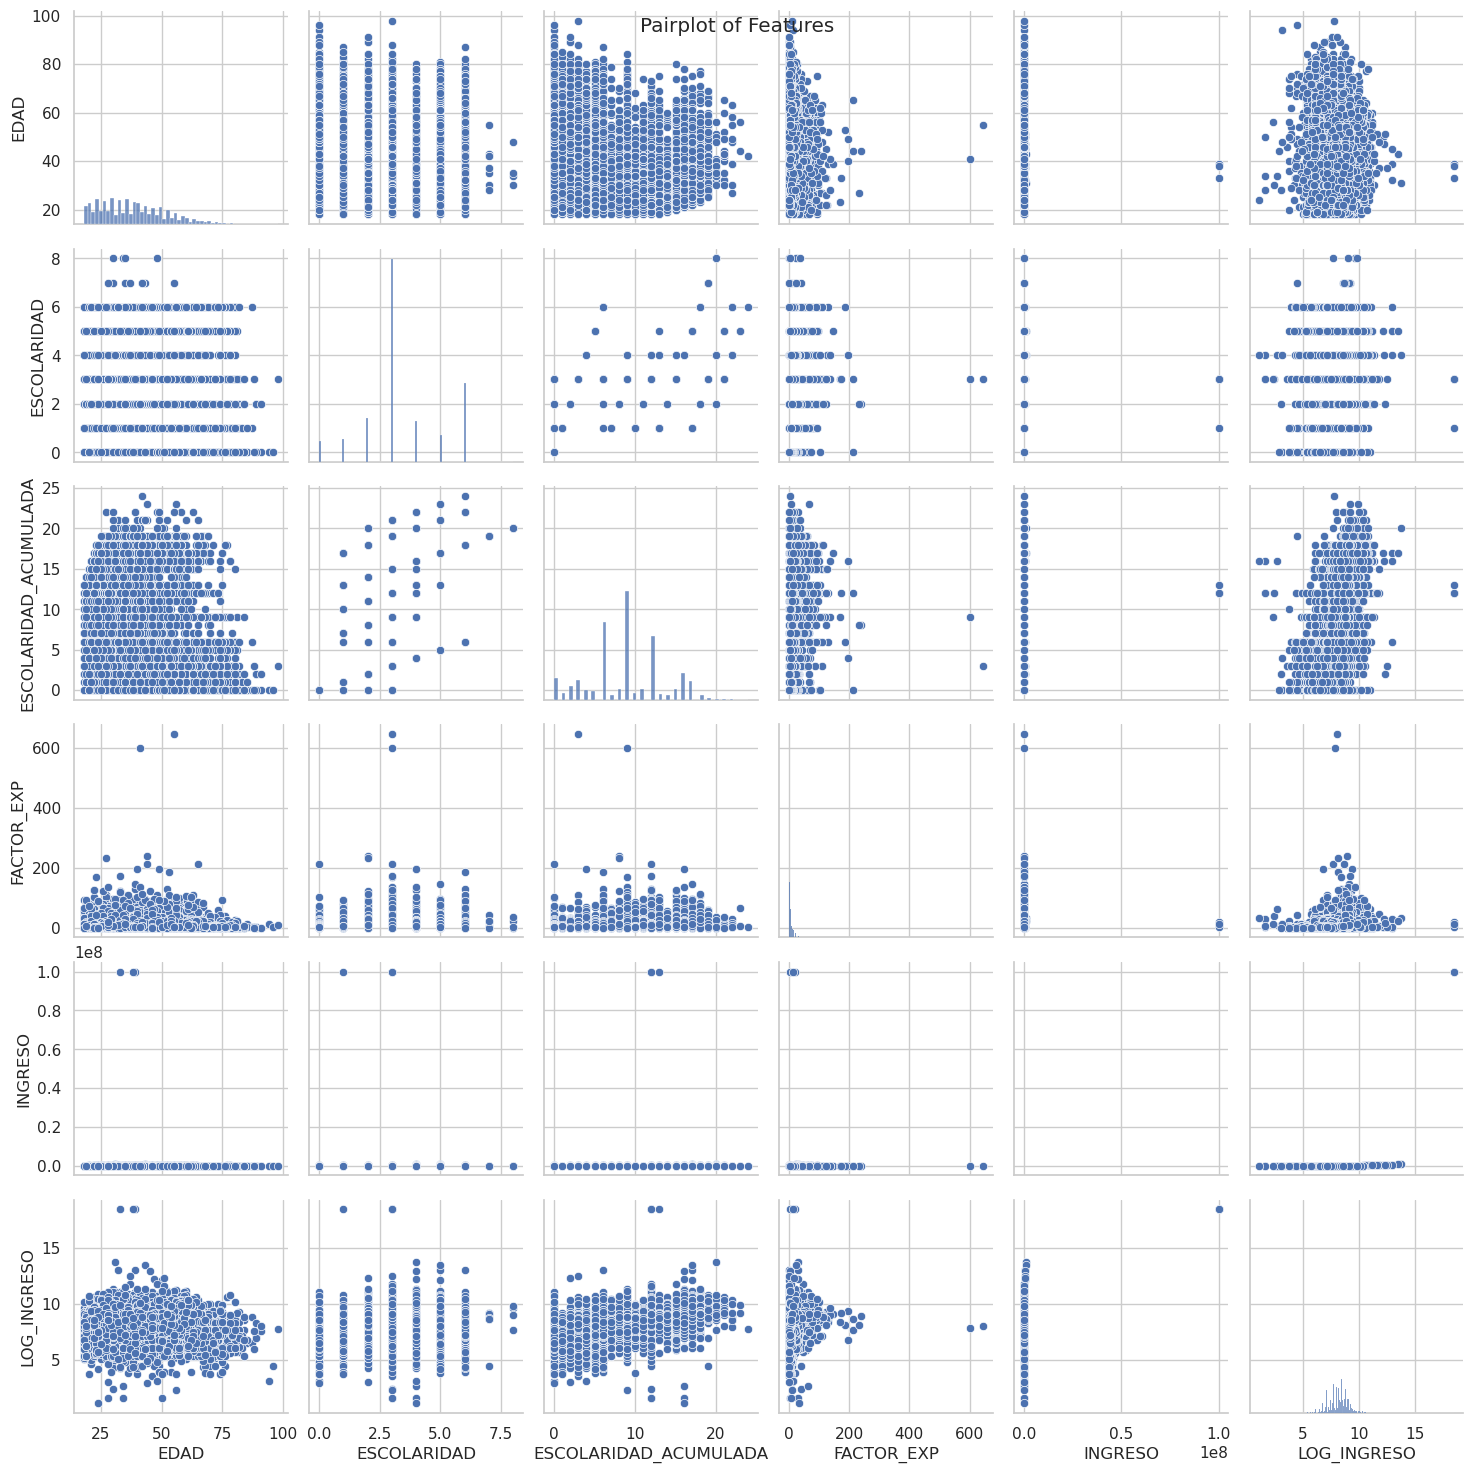

In [16]:
# Plot pairplot to visualize relationships between features
sns.pairplot(train_data[continuous_vars])
plt.suptitle("Pairplot of Features")
plt.show()

To explore linear relationships between the continuous variables in our dataset, we compute the correlation matrix. This helps identify:
- Potential multicollinearity issues
- Strong predictors of income (INGRESO or LOG_INGRESO)
- Redundancy or independence among variables

/tmp/ipykernel_70785/541619347.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = train_data.corr()


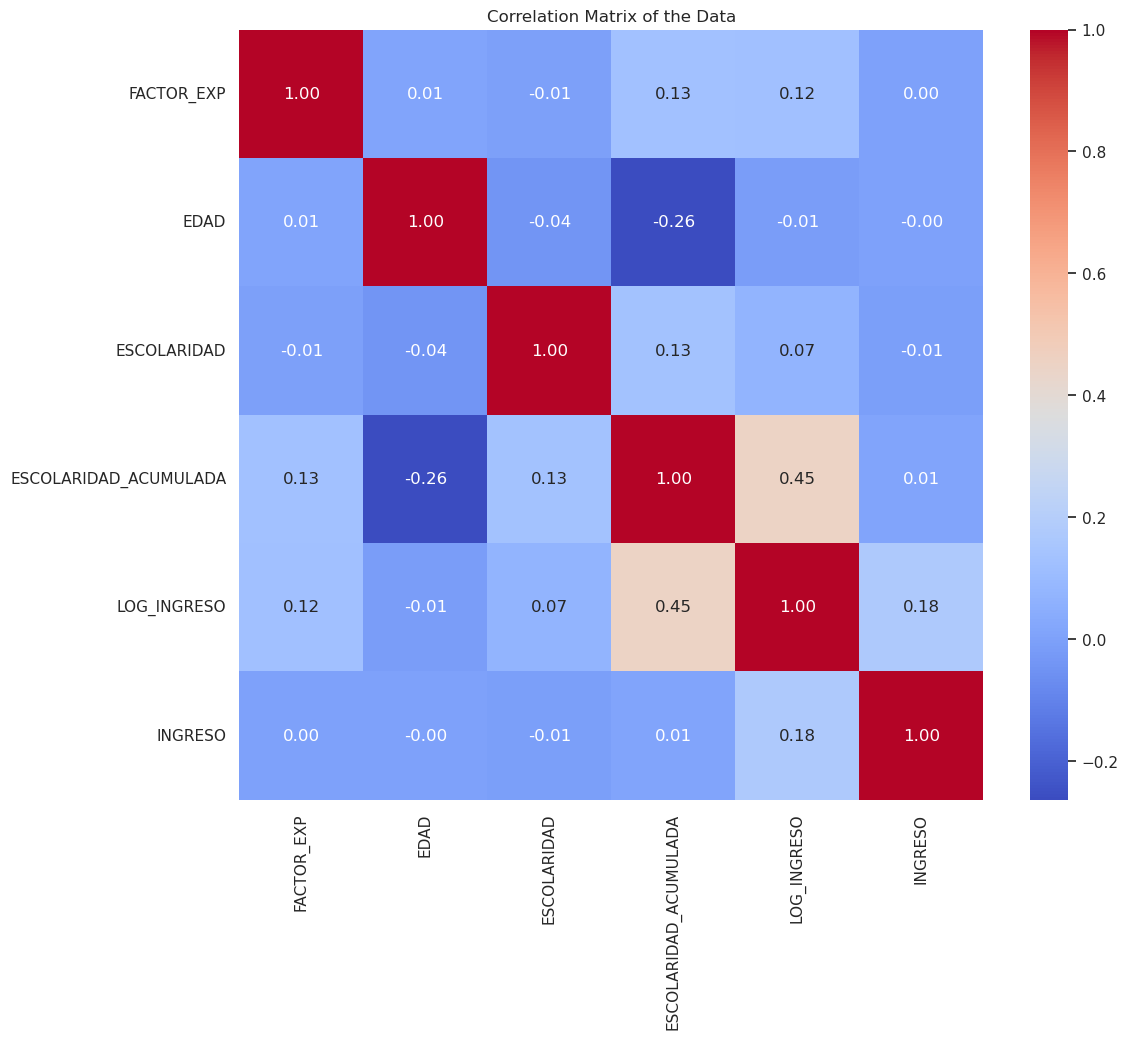

In [17]:
# Calculate the correlation matrix
correlation_matrix = train_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of the Data')
plt.show()

📊 Distribution of Categorical Variables

To understand the composition of our dataset, we visualize the most frequent categories across all categorical features. This helps:
- Detect imbalanced variables
- Identify common groups for features like RELIGION, SEXO, ACTPRIMARIA, etc.
- Inform decisions on encoding techniques (e.g., one-hot vs. target encoding)

We plot only the top 10 categories for each variable to keep the charts interpretable.


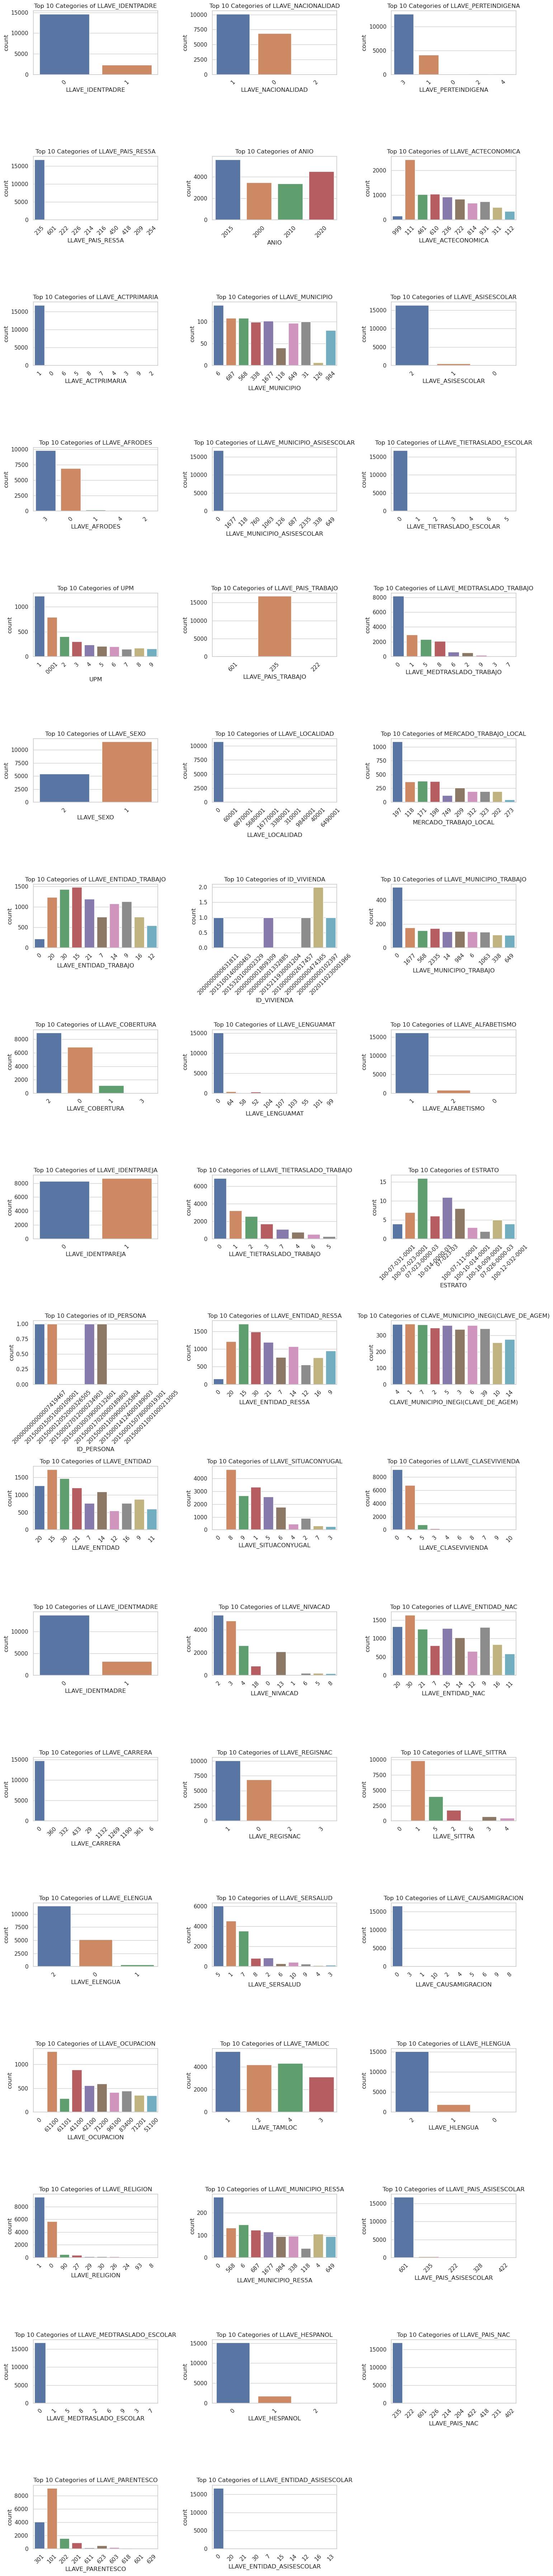

In [18]:
# 4) 4. Plot Categorical Variables (Bar Plots)

n_cols = 3
n_rows = -(-len(categorical_vars) // n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for i, col in enumerate(categorical_vars):
    sns.countplot(data=train_data, x=col, ax=axs[i], order=df[col].value_counts().index[:10])
    axs[i].set_title(f"Top 10 Categories of {col}")
    axs[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

## Preparing the Data for Machine Learning

After the exploratory phase, including the inspection of distributions and correlation structures, we now prepare the data for predictive modeling.

This step involves:
- Handling missing values (already addressed)
- Engineering polynomial and interaction terms
- Scaling and encoding features appropriately
- Building preprocessing pipelines for continuous and categorical variables

This transformation ensures that the data is clean, structured, and model-ready, allowing us to evaluate the importance of education and other variables in predicting income.



🎯 Variable Selection Strategy

From the extensive list of variables retained after the exploratory phase, we apply two key criteria to select the most relevant predictors for modeling:
1. Theoretical Justification / Literature Review:
    Variables that are widely recognized in the academic literature as important determinants of income—such as education, age, sex, and occupational characteristics—are prioritized. These variables are expected to capture human capital, demographic effects, and labor market positioning.
    
2. Data Quality and Signal Strength: 
    While many variables had acceptable missing data rates (below 10.5%), some had categories overwhelmingly dominated by “Not specified” or similar responses. These variables likely introduce more noise than signal and were therefore excluded.

Additionally:
- In cases of strong multicollinearity (e.g., ESCOLARIDAD and ESCOLARIDAD_ACUMULADA), we retain only the variable that is more interpretable or better suited to our research objective.
- We exclude high-cardinality identifiers (like ID_PERSONA, ID_VIVIENDA) and variables that are not meaningful for income prediction.

✅ The result is a refined set of features that are both substantively relevant and statistically sound, ensuring better model performance and interpretability.

In [19]:
# 🎯 Target Variable
target_variable = ['LOG_INGRESO']

# 🌍 Geographical / Labor Market Context
geographical_context = ['MERCADO_TRABAJO_LOCAL']  # Local Labor Market

# 📅 Temporal Variable
temporal_variable = ['ANIO']

# 🛠️ Work and Commute Characteristics
work_characteristics = [
    'LLAVE_TIETRASLADO_TRABAJO',  # Commute time to work
    'LLAVE_ACTPRIMARIA'           # Primary activity
]

# 🎓 Education
education_variables = [
    'ESCOLARIDAD_ACUMULADA',      # Accumulated schooling
]

# 🧍 Sociodemographic Characteristics
sociodemographic_variables = [
    'EDAD',                       # Age
    'LLAVE_SITUACONYUGAL',        # Marital status
    'LLAVE_PERTEINDIGENA',        # Indigenous identity
    'LLAVE_RELIGION',             # Religion
    'LLAVE_AFRODES',              # Afrodescendant identity
    'LLAVE_SEXO'                  # Sex
]

# ✅ Combine all selected variables into one list
selected_columns = (
    target_variable + 
    geographical_context +
    temporal_variable +
    work_characteristics +
    education_variables +
    sociodemographic_variables
)

# 🎯 Create a new DataFrame with only the selected variables
train_data_selected = train_data[selected_columns].copy()

# 🖨️ Optional: Check shape and preview
print(f"✅ Selected dataset shape: {train_data_selected.shape}")
train_data_selected.head(5)

✅ Selected dataset shape: (17001, 12)


,LOG_INGRESO,MERCADO_TRABAJO_LOCAL,ANIO,LLAVE_TIETRASLADO_TRABAJO,LLAVE_ACTPRIMARIA,ESCOLARIDAD_ACUMULADA,EDAD,LLAVE_SITUACONYUGAL,LLAVE_PERTEINDIGENA,LLAVE_RELIGION,LLAVE_AFRODES,LLAVE_SEXO
24134,8.630700,640,2010,0,1,12.0,43.0,8,3,1,0,2
9692,8.294300,562,2000,0,1,16.0,28.0,9,3,1,0,2
71831,8.415382,438,2020,5,1,0.0,71.0,4,1,1,3,1
35758,7.852439,65,2015,1,1,9.0,29.0,1,3,0,3,1
40856,6.754604,478,2015,6,1,9.0,24.0,1,1,0,3,2


In [20]:
# Describe the continous variables
train_data_selected.describe()

,LOG_INGRESO,ESCOLARIDAD_ACUMULADA,EDAD
count,17001.000000,17001.000000,17001.000000
mean,8.152509,8.845009,38.113993
std,0.914989,4.559867,13.470441
min,1.098612,0.000000,18.000000
25%,7.670429,6.000000,27.000000
50%,8.243019,9.000000,36.000000
75%,8.699681,12.000000,47.000000
max,18.420681,24.000000,98.000000


📈 Income Trends by Education Level Across Time

To visually explore how the importance of education in determining income has evolved over time, we compute and plot the average (log) income by education level for different years.

In [21]:
# Show all rows in the terminal output
pd.set_option('display.max_rows', None)

# Group by ANIO and ESCOLARIDAD_ACUMULADA and calculate average log income
avg_income_by_year_edu = train_data_selected.groupby(
    ['ANIO', 'ESCOLARIDAD_ACUMULADA']
)['LOG_INGRESO'].mean().reset_index()

# Print full output 
print(avg_income_by_year_edu)

# Optionally reset the display setting afterward
pd.reset_option('display.max_rows')

    ANIO  ESCOLARIDAD_ACUMULADA  LOG_INGRESO
0   2000                    0.0     6.869821
1   2000                    1.0     6.984628
2   2000                    2.0     7.017757
3   2000                    3.0     7.162910
4   2000                    4.0     7.252719
5   2000                    5.0     7.138195
6   2000                    6.0     7.395202
7   2000                    7.0     7.389048
8   2000                    8.0     7.551628
9   2000                    9.0     7.584606
10  2000                   10.0     7.849443
11  2000                   11.0     7.739078
12  2000                   12.0     7.956250
13  2000                   13.0     8.258036
14  2000                   14.0     8.185911
15  2000                   15.0     8.189349
16  2000                   16.0     8.738000
17  2000                   17.0     8.713493
18  2000                   18.0     9.256900
19  2000                   19.0     9.196793
20  2000                   20.0     9.446799
21  2000  

This grouped data is visualized using a line plot, where each line corresponds to a different year.

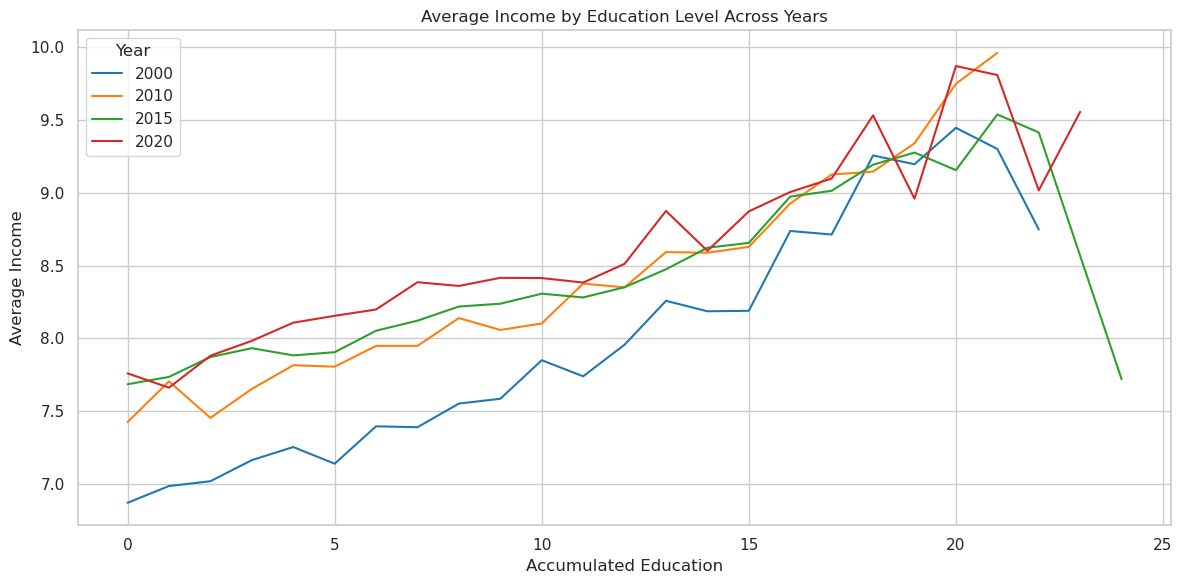

In [23]:
# Remove NaNs to avoid plot issues
avg_income_by_year_edu_clean = avg_income_by_year_edu.dropna()

plt.figure(figsize=(12, 6))
sns.lineplot(data=avg_income_by_year_edu_clean,
             x='ESCOLARIDAD_ACUMULADA',
             y='LOG_INGRESO',
             hue='ANIO',
             palette='tab10')

plt.title("Average Income by Education Level Across Years")
plt.xlabel("Accumulated Education")
plt.ylabel("Average Income")
plt.legend(title="Year")
plt.tight_layout()
plt.show()

To prepare our dataset for modeling, we divide the selected predictors into numerical and categorical features. This is essential for building preprocessing pipelines and ensuring that each variable is treated appropriately during transformation and model fitting.

In [25]:
# ✅ Split into categorical and continuous variable lists
numerical_features = [
    'ESCOLARIDAD_ACUMULADA',
    'EDAD'
]
categorical_features = [
    'MERCADO_TRABAJO_LOCAL',
    'LLAVE_TIETRASLADO_TRABAJO',
    'LLAVE_ACTPRIMARIA',
    'LLAVE_SITUACONYUGAL',
    'LLAVE_PERTEINDIGENA',
    'LLAVE_RELIGION',
    'LLAVE_AFRODES',
    'LLAVE_SEXO'
]

The number of categories in each of the variables is:

In [24]:
# Get categorical columns
categorical_features = train_data_selected.select_dtypes(include='category').columns

# Count number of unique categories for each categorical variable
category_counts = {col: train_data_selected[col].nunique() for col in categorical_features}
category_counts_df = pd.DataFrame.from_dict(category_counts, orient='index', columns=['Num Categories'])

# Sort by number of categories (optional)
category_counts_df = category_counts_df.sort_values(by='Num Categories', ascending=False)

# Display
print(category_counts_df)

                           Num Categories
MERCADO_TRABAJO_LOCAL                 724
LLAVE_RELIGION                         49
LLAVE_SITUACONYUGAL                    10
LLAVE_TIETRASLADO_TRABAJO               8
LLAVE_PERTEINDIGENA                     5
LLAVE_AFRODES                           5
ANIO                                    4
LLAVE_ACTPRIMARIA                       2
LLAVE_SEXO                              2


## Preprocessing Strategy

To prepare the data for modeling, we must transform both numerical and categorical variables in ways that preserve useful information while ensuring compatibility with machine learning algorithms.

⸻

⚙️ Handling Missing Values

One common preprocessing challenge is dealing with missing values. Scikit-Learn provides a convenient SimpleImputer class for this purpose. For numerical variables, we typically fill missing values with the median, which is robust to outliers.

In our case, the variable ESCOLARIDAD_ACUMULADA (accumulated education) has a relatively high missing rate (~10%). Since this variable is central to our research question, we impute missing values using the median from the training set.

⸻

⚙️ Handling Categorical Variables

Categorical variables differ significantly in their number of unique values (cardinality). To encode them effectively:
1. Low-cardinality variables (≤ 10 categories):
	We apply One-Hot Encoding, which creates a binary column for each category. This encoding is interpretable and suitable for linear models.
2. High-cardinality variables (≫ 10 categories):
	We apply Target Encoding (also called Mean Encoding), which replaces each category with the average target value (in this case, income) for that category. This avoids sparse matrices and helps capture more informative patterns.

💡 In our dataset:
- MERCADO_TRABAJO_LOCAL has 774 unique values → encoded with Target Encoding
- All other categorical variables → encoded with One-Hot Encoding

⸻

⚙️ Handling Numerical Variables

Numerical variables are scaled using StandardScaler, which standardizes each feature to have a mean of 0 and a standard deviation of 1. This step is essential for regularized models such as Ridge and Lasso, where the scale of variables directly influences coefficient shrinkage.

⸻

🛠 Combined Preprocessing Pipeline

We use Scikit-Learn’s ColumnTransformer to combine the preprocessing steps into a unified pipeline:
- 📐 Numerical pipeline: SimpleImputer (median) + StandardScaler
- 🔢 Categorical pipeline (low-cardinality): OneHotEncoder
- 🎯 Categorical pipeline (high-cardinality): TargetEncoder

This structure allows us to handle mixed data types cleanly, reduce data leakage, and facilitate reproducibility and model tuning.

In [26]:
# 🔍 Identify high-cardinality categorical features
high_card_cat = ['MERCADO_TRABAJO_LOCAL']  # Contains many unique categories → Target Encoding

# 🏷️ Remaining categorical variables are considered low-cardinality
low_card_cat = list(set(categorical_features) - set(high_card_cat))

# 🎯 Define interaction features (e.g., education × year)
interaction_features = ['ESCOLARIDAD_ACUMULADA', 'ANIO']

# 🔢 Final list of numerical features, including those used for interactions
numerical_features = list(set(numerical_features + interaction_features))

# 🧮 Numerical pipeline: Imputation + Polynomial terms (interactions) + Scaling
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),                  # Fill missing values with median
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),     # Add interaction & quadratic terms
    ('scaler', StandardScaler())                                    # Standardize features
])

# 🧠 High-cardinality pipeline: Target Encoding (mean encoding)
high_card_pipeline = Pipeline([
    ('target_encoder', TargetEncoder())                             # Encode using mean income
])

# 🔤 Low-cardinality pipeline: Mode Imputation + One-Hot Encoding
low_card_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),           # Fill with most frequent category
    ('onehot', OneHotEncoder(handle_unknown="ignore"))              # Handle categorical dummies
])

# 🔧 Combine all pipelines using ColumnTransformer
full_pipeline = ColumnTransformer([
    ('num', num_pipeline, numerical_features),                      # Apply to numeric columns
    ('low_card', low_card_pipeline, low_card_cat),                  # Apply to low-card categorical
    ('high_card', high_card_pipeline, high_card_cat)                # Apply to high-card categorical
])

Before fitting any models, we separate the target variable (LOG_INGRESO) from the features, and use the preprocessing pipeline we defined earlier to transform the inputs.

In [27]:
# Separate features and target
X_train = train_data_selected.drop(columns=['LOG_INGRESO'])
y_train = train_data_selected['LOG_INGRESO']

# Fit the full pipeline and transform the data
X_train_prepared = full_pipeline.fit_transform(X_train, y_train)

# Now that the pipeline is fitted, extract feature names
feature_names = full_pipeline.get_feature_names_out()

## Regression Models: Training, Evaluation, and Interpretation

⚙️ Modeling Workflow for Each Algorithm

For each model (Linear, Ridge, Lasso, Random Forest, Gradient Boosting), we follow the same logical structure:
1.	Model Definition & Cross-Validation
	We define the model and use 5-fold cross-validation to evaluate:
	- Mean Squared Error (MSE)
	- Variance of prediction errors
2.	Model Training
	The model is retrained on the full training set to make use of all available data.
3.	Feature Importance
	We analyze which features drive the model using one or more of the following:
	- Coefficients (for linear models)
	- Feature importances (for tree-based models)
	- SHAP values, which provide a unified measure of each variable’s contribution
4.	Visualization
	We plot:
	- Top predictors using coefficient magnitudes or SHAP importance

📊 Model 1: Linear Regression

Linear Regression serves as our baseline model. It assumes a linear relationship between the predictors and the target variable (LOG_INGRESO). It’s simple, interpretable, and useful for understanding how each feature contributes to the prediction.

✅ What Linear Regression does:
- Estimates coefficients for each feature to minimize the sum of squared errors
- Provides a fully interpretable model with directly measurable effect sizes
- Assumes no regularization, which can be problematic in the presence of multicollinearity or many correlated features

In [81]:
# 1. Define the linear regression model
lr_model = LinearRegression()

# 2. Perform 5-fold cross-validation using negative MSE as the scoring metric
mse_scores = cross_val_score(lr_model, X_train_prepared, y_train, cv=5, scoring='neg_mean_squared_error')

# Convert negative MSE scores to positive values
mse_scores = -mse_scores

# Compute the mean and variance of the MSE across folds
mean_mse = mse_scores.mean()
variance_mse = mse_scores.var()

# Print evaluation metrics
print(f"🔁 Cross-validated Mean Squared Error (MSE): {mean_mse:.4f}")
print(f"📉 Variance of MSE: {variance_mse:.6f}")

# 3. Fit the model on the full training set
lr_model.fit(X_train_prepared, y_train)

# 4. Extract model coefficients and corresponding feature names
coefficients = lr_model.coef_
feature_names = full_pipeline.get_feature_names_out()

# Create a DataFrame to store and sort coefficients by absolute value
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df_sorted = coef_df.sort_values("Abs_Coefficient", ascending=False)

# Print the top 10 most impactful features
print("\n📌 Top 15 most impactful features:")
print(coef_df_sorted.head(15))

🔁 Cross-validated Mean Squared Error (MSE): 0.4850
📉 Variance of MSE: 0.001324

📌 Top 15 most impactful features:
                             Feature  Coefficient  Abs_Coefficient
4    num__ANIO ESCOLARIDAD_ACUMULADA     -21.8406          21.8406
1         num__ESCOLARIDAD_ACUMULADA      21.6470          21.6470
2                          num__EDAD       7.5093           7.5093
5                     num__ANIO EDAD      -7.2227           7.2227
67       low_card__LLAVE_RELIGION_89      -1.7220           1.7220
40       low_card__LLAVE_RELIGION_18      -1.4302           1.4302
66       low_card__LLAVE_RELIGION_88      -1.1386           1.1386
90  high_card__MERCADO_TRABAJO_LOCAL       1.0632           1.0632
59       low_card__LLAVE_RELIGION_63      -0.9046           0.9046
52       low_card__LLAVE_RELIGION_31      -0.8541           0.8541
32        low_card__LLAVE_RELIGION_4      -0.8450           0.8450
76      low_card__LLAVE_RELIGION_213       0.8298           0.8298
60       low_ca

To assess the performance of the linear regression model, we visualize the relationship between the actual and predicted values of log-transformed income.

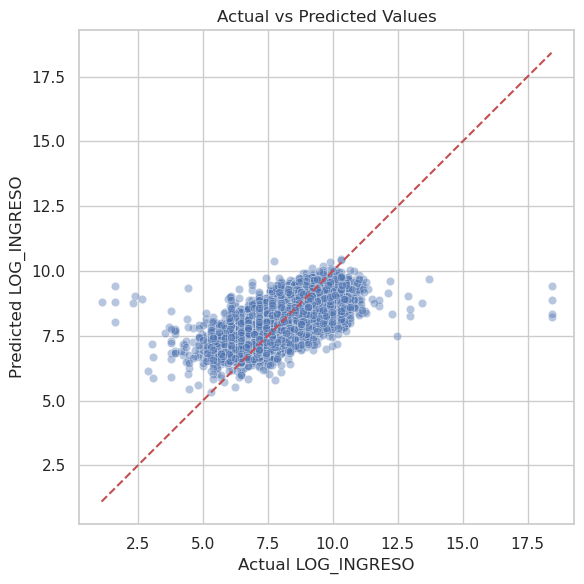

In [82]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_train, y=y_pred, alpha=0.4)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--')
plt.xlabel("Actual LOG_INGRESO")
plt.ylabel("Predicted LOG_INGRESO")
plt.title("Actual vs Predicted Values")
plt.tight_layout()
plt.show()

To better interpret the results of our linear regression model, we visualize the top features ranked by the magnitude of their coefficients. This allows us to quickly identify which variables have the strongest association with income (positive or negative), and supports our goal of understanding the evolving role of education and other factors.

<Figure size 1000x600 with 0 Axes>

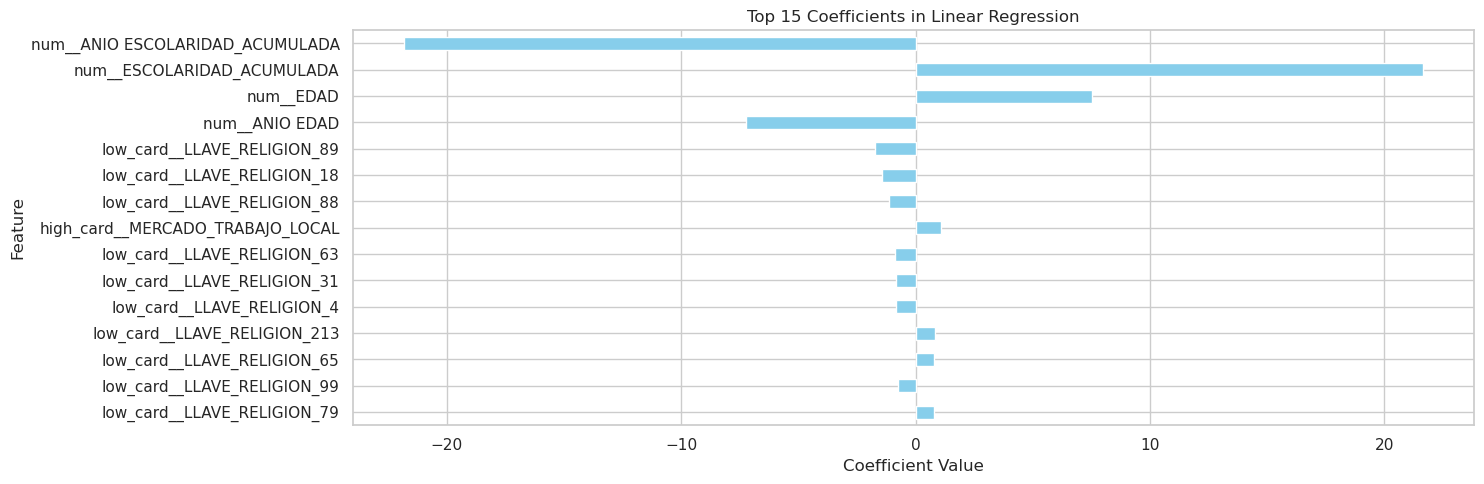

In [83]:
# Define the number of top features to display
top_n = 15  # You can change this number to show more or fewer features

# Plot the top coefficients as a horizontal bar chart
plt.figure(figsize=(10, 6))
coef_df_sorted.head(top_n).plot(
    kind='barh',             # Horizontal bar plot
    x='Feature', 
    y='Coefficient', 
    color='skyblue', 
    legend=False
)

# Customize plot appearance
plt.title(f"Top {top_n} Coefficients in Linear Regression")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.grid(True, axis='x')
plt.tight_layout()
plt.gca().invert_yaxis()  # Most important feature at the top

# Show the plot
plt.show()

To evaluate whether the importance of education in predicting income has increased over the years, we visualize the relationship between predicted income and years of education, grouped by year.

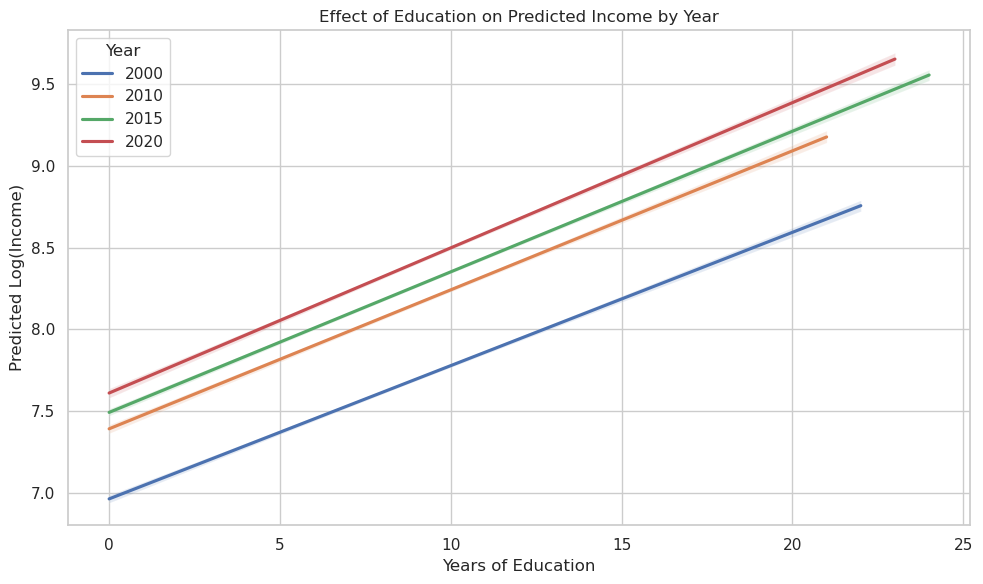

In [84]:
# Reconstruct the original features if needed
X_train_df = pd.DataFrame(X_train_prepared.toarray(), columns=feature_names)

# Add predictions back to a copy of the original X
X_vis = X_train.copy()
X_vis['Predicted_LOG_INGRESO'] = model.predict(X_train_prepared)

# Select the most recent 5 years for plotting
years_to_plot = sorted(X_vis['ANIO'].unique())[-5:]  # Last 5 years

# Create the plot
plt.figure(figsize=(10, 6))
for year in years_to_plot:
    subset = X_vis[X_vis['ANIO'] == year]
    sns.regplot(
        data=subset,
        x='ESCOLARIDAD_ACUMULADA',
        y='Predicted_LOG_INGRESO',
        label=str(year),
        scatter=False  # Show lines, not dots
    )

# Customize the plot
plt.title("Effect of Education on Predicted Income by Year")
plt.xlabel("Years of Education")
plt.ylabel("Predicted Log(Income)")
plt.legend(title="Year")
plt.tight_layout()
plt.show()

To interpret the linear regression model beyond raw coefficients, we apply SHAP (SHapley Additive exPlanations) — a method grounded in cooperative game theory that attributes the impact of each feature on individual predictions.

While coefficients tell us the average direction and strength of a feature, SHAP values provide instance-level explanations, revealing how each feature pushes the prediction higher or lower.

We visualize the top 15 most influential features using:
1. A bar plot summarizing average SHAP importance
2. A beeswarm plot showing the distribution and direction of each feature’s impact


/users/eleves-b/2024/anahi.reyes-miguel/.local/lib/python3.11/site-packages/shap/explainers/_linear.py:99: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


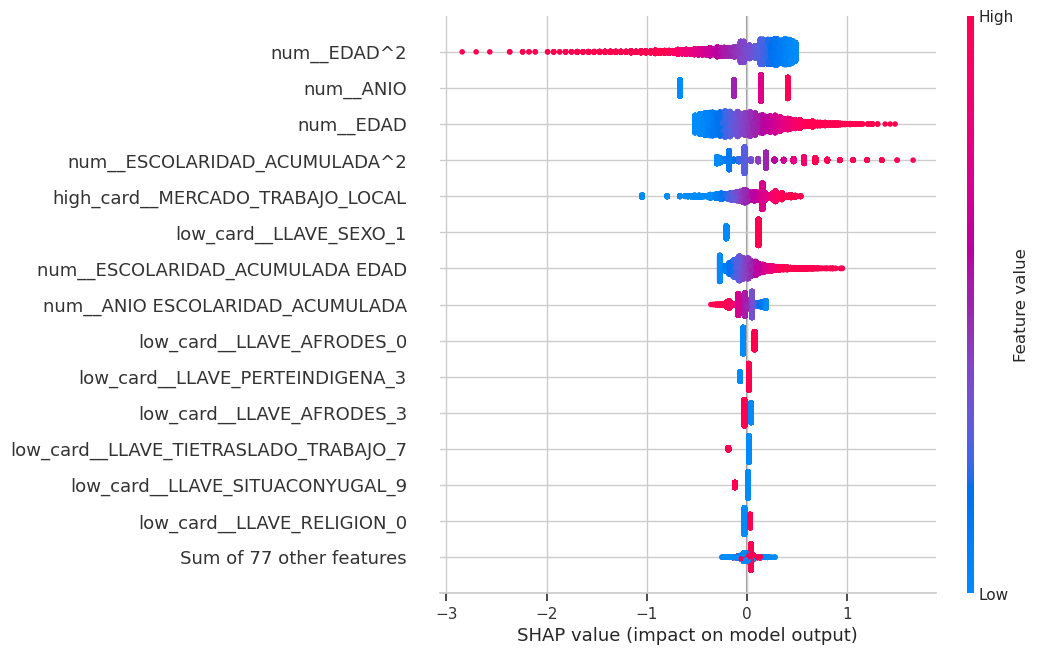

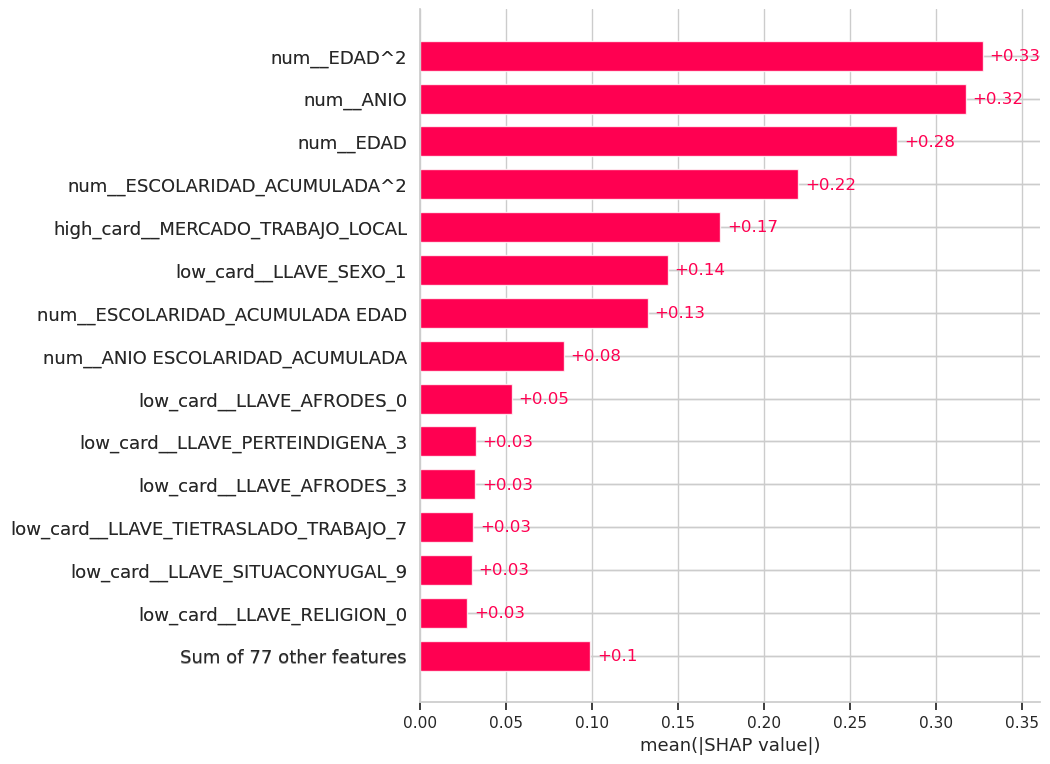

In [85]:
# ✅ SHAP explainer for Linear Regression
explainer = shap.LinearExplainer(model, X_train_prepared, feature_perturbation="interventional")

# ✅ Compute SHAP values
shap_values = explainer(X_train_prepared)

# ✅ Use feature names in plot
shap_values.feature_names = full_pipeline.get_feature_names_out().tolist()

# SHAP beeswarm with names
shap.plots.beeswarm(shap_values, max_display=15)

# ✅ SHAP bar plot with feature names
shap.plots.bar(shap_values, max_display=15)


⚖️ Regularized Linear Models

In high-dimensional settings or when features are strongly correlated, plain linear regression can suffer from overfitting or unstable coefficient estimates. To address this, we apply regularization — a technique that adds a penalty to large model coefficients, helping control model complexity and improve generalization.

Instead of reducing the number of polynomial degrees (as often done in polynomial regression), we constrain the magnitude of the coefficients to prevent over-reliance on any single variable.

We explore two common regularized linear models:
1. Lasso Regression (L1 penalty)
2. Ridge Regression (L2 penalty)

These models offer a useful trade-off between interpretability and performance, especially when dealing with multicollinearity or large feature spaces.

📊 Model 2: Lasso

Lasso Regression is especially useful when you want to simplify your model and identify the most relevant predictors. Unlike Ridge, Lasso doesn’t just shrink coefficients—it can eliminate them entirely.

✅ What Lasso does:
- Performs L1 regularization, which penalizes the absolute value of coefficients
- Drives some coefficients to exactly zero, effectively performing feature selection
- Helps interpretability by identifying which variables truly matter
- Useful when you expect only a subset of features to be informative


In [ ]:
# ✅ Fit Lasso Regression with cross-validation
# We use LassoCV to automatically select the best regularization strength (alpha)
# `max_iter` is increased to ensure convergence for complex datasets
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_prepared, y_train)

# 🔢 Report the best alpha selected during cross-validation
print(f"✅ Best alpha (λ): {lasso.alpha_:.5f}")

# 📊 Evaluate model performance on training set
y_pred = lasso.predict(X_train_prepared)
mse = mean_squared_error(y_train, y_pred)  # Mean Squared Error
variance = np.var((y_train - y_pred) ** 2)  # Variance of prediction errors

# 📉 Print performance metrics
print(f"📉 Lasso MSE: {mse:.4f}")
print(f"📉 Variance of prediction errors: {variance:.6f}")

✅ Best alpha (λ): 0.00041
📉 Lasso MSE: 0.4873
📉 Variance of prediction errors: 4.211853


In [38]:
# 📎 Extract Lasso coefficients and link them to feature names
feature_names = full_pipeline.get_feature_names_out()
lasso_coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lasso.coef_
})

# 🧮 Count non-zero coefficients (i.e., features retained by Lasso)
nonzero = lasso_coef_df[lasso_coef_df["Coefficient"] != 0]
print(f"🧹 Non-zero coefficients: {len(nonzero)} out of {len(feature_names)}")

🧹 Non-zero coefficients: 37 out of 91


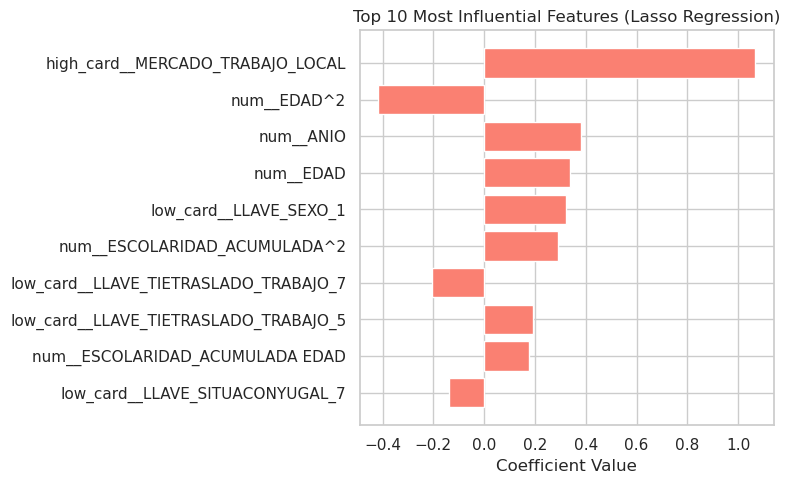

In [41]:
# 📊 Visualize the top 10 non-zero Lasso coefficients
# Sort by absolute magnitude of the coefficients
top = nonzero.reindex(nonzero["Coefficient"].abs().sort_values(ascending=False).index).head(10)

# Create horizontal bar chart
plt.figure(figsize=(8, 5))
plt.barh(top["Feature"], top["Coefficient"], color='salmon')
plt.xlabel("Coefficient Value")
plt.title("Top 10 Most Influential Features (Lasso Regression)")
plt.gca().invert_yaxis()  # Highest value at the top
plt.tight_layout()
plt.show()

To better understand how each variable influences the predictions from our Lasso Regression model, we use SHAP (SHapley Additive exPlanations).

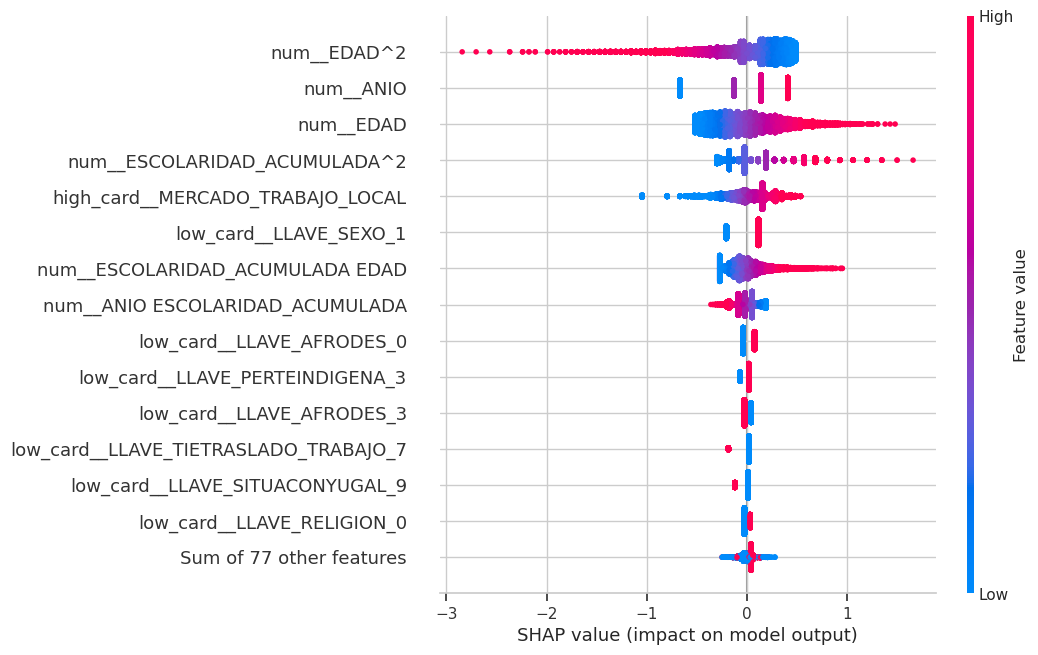

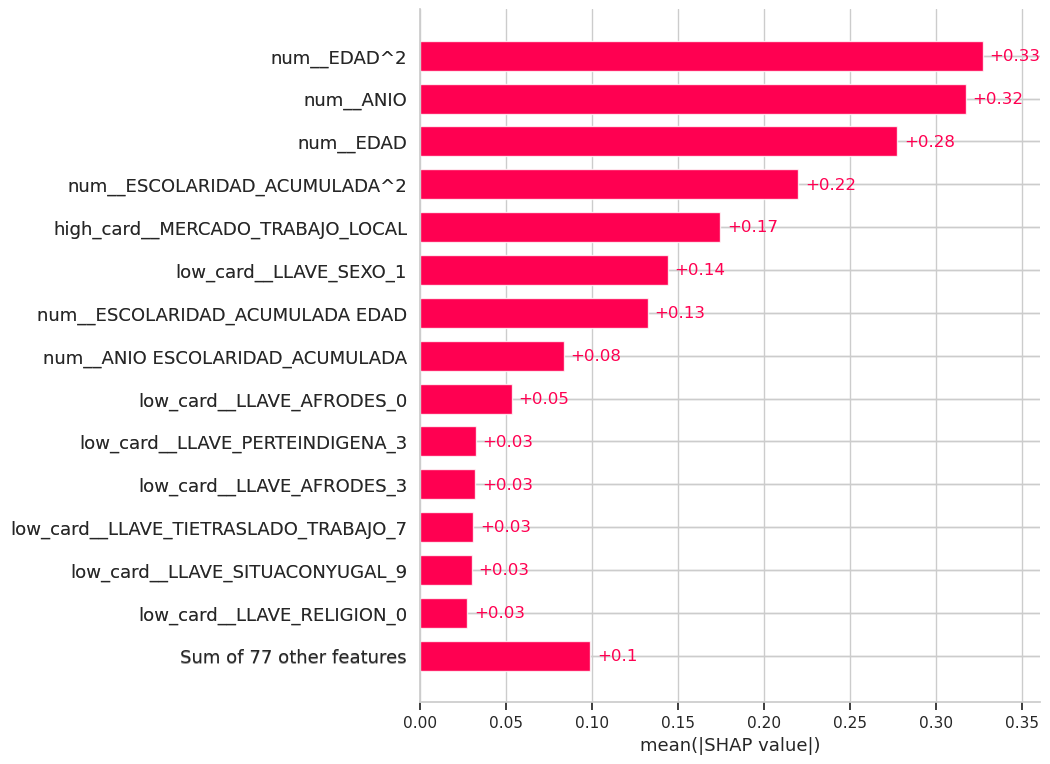

In [51]:
# ✅ Select the fitted Lasso model
model = lasso  

# 🧠 Create a SHAP Explainer using the linear algorithm (suited for linear models)
explainer = shap.Explainer(model, X_train_prepared, feature_names=feature_names, algorithm="linear")

# 🔍 Compute SHAP values for the training data
shap_values = explainer(X_train_prepared)

# 📊 Beeswarm plot: shows the impact of each feature across all observations
shap.plots.beeswarm(shap_values, max_display=15)

# 📈 Bar plot: ranks features by average absolute SHAP value
shap.plots.bar(shap_values, max_display=15)

📊 Model 3: Ridge

Ridge Regression is a great next step. It’s similar to Lasso, but instead of eliminating features (like Lasso does), it shrinks all coefficients—especially helpful when you have multicollinearity or highly correlated predictors.

✅ What Ridge does:
- Performs L2 regularization, which reduces the size of coefficients but does not force them to zero
- Stabilizes the model when you have many correlated features (like polynomial and interaction terms)
- Is often more stable than Lasso when your predictors are highly collinear


In [43]:
# ✅ Fit Ridge Regression with cross-validated alpha
# RidgeCV automatically selects the best regularization strength (alpha) from a range
alphas = np.logspace(-6, 2, 100)  # Explore alpha values from 10^-6 to 10^2
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train_prepared, y_train)

# 🔢 Print selected alpha (regularization parameter)
print(f"✅ Best alpha (λ): {ridge.alpha_:.5f}")

# 📊 Evaluate model performance on training data
y_pred = ridge.predict(X_train_prepared)
mse = mean_squared_error(y_train, y_pred)
variance = np.var((y_train - y_pred) ** 2)

print(f"📉 Ridge MSE: {mse:.4f}")
print(f"📉 Variance of prediction errors: {variance:.6f}")

✅ Best alpha (λ): 0.00206
📉 Ridge MSE: 0.4806
📉 Variance of prediction errors: 4.144049


In [46]:
# 🔍 Extract coefficients and feature names from the fitted Ridge model
ridge_coefficients = ridge.coef_
feature_names = full_pipeline.get_feature_names_out()

# 🧾 Build a DataFrame linking each feature to its corresponding coefficient
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": ridge_coefficients
})

# 📏 Compute absolute values to assess relative importance
coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()

# 📊 Sort by absolute value and display top 15 features
top_ridge_coefs = coef_df.sort_values("Abs_Coefficient", ascending=False).head(15)

# 📋 Display the table
print("📌 Top 15 Features by Ridge Coefficient Magnitude:\n")
print(top_ridge_coefs[["Feature", "Coefficient"]].to_string(index=False))

📌 Top 15 Features by Ridge Coefficient Magnitude:

                         Feature  Coefficient
 num__ANIO ESCOLARIDAD_ACUMULADA   -20.882839
      num__ESCOLARIDAD_ACUMULADA    20.697043
                       num__EDAD     3.338693
                  num__ANIO EDAD    -3.032852
     low_card__LLAVE_RELIGION_89    -1.644308
     low_card__LLAVE_RELIGION_18    -1.383251
     low_card__LLAVE_RELIGION_88    -1.098336
high_card__MERCADO_TRABAJO_LOCAL     1.061674
    low_card__LLAVE_RELIGION_213     0.883767
     low_card__LLAVE_RELIGION_63    -0.828241
     low_card__LLAVE_RELIGION_65     0.815212
     low_card__LLAVE_RELIGION_13    -0.789743
     low_card__LLAVE_RELIGION_31    -0.787503
      low_card__LLAVE_RELIGION_4    -0.764029
     low_card__LLAVE_RELIGION_99    -0.732239


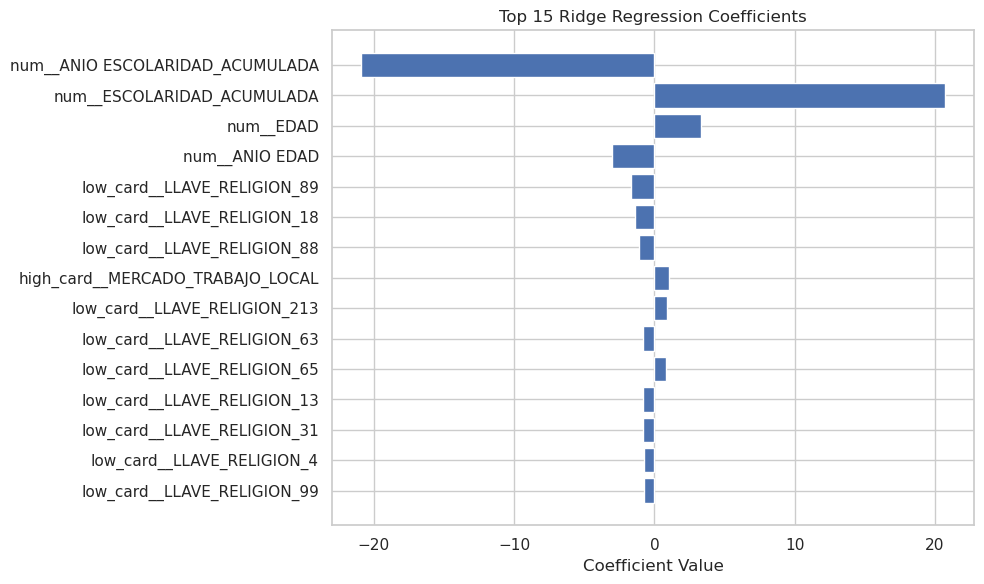

In [ ]:
# 📊 Bar plot of top 15 coefficients
plt.figure(figsize=(10, 6))
plt.barh(coef_df_sorted["Feature"], coef_df_sorted["Coefficient"])
plt.gca().invert_yaxis()
plt.title("Top 15 Ridge Regression Coefficients")
plt.xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

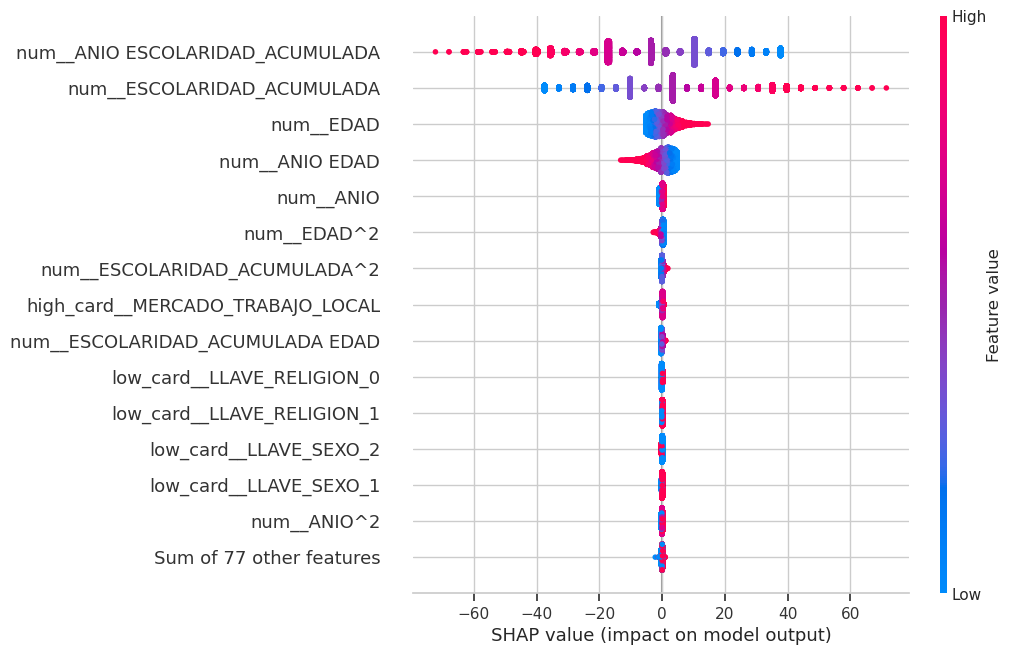

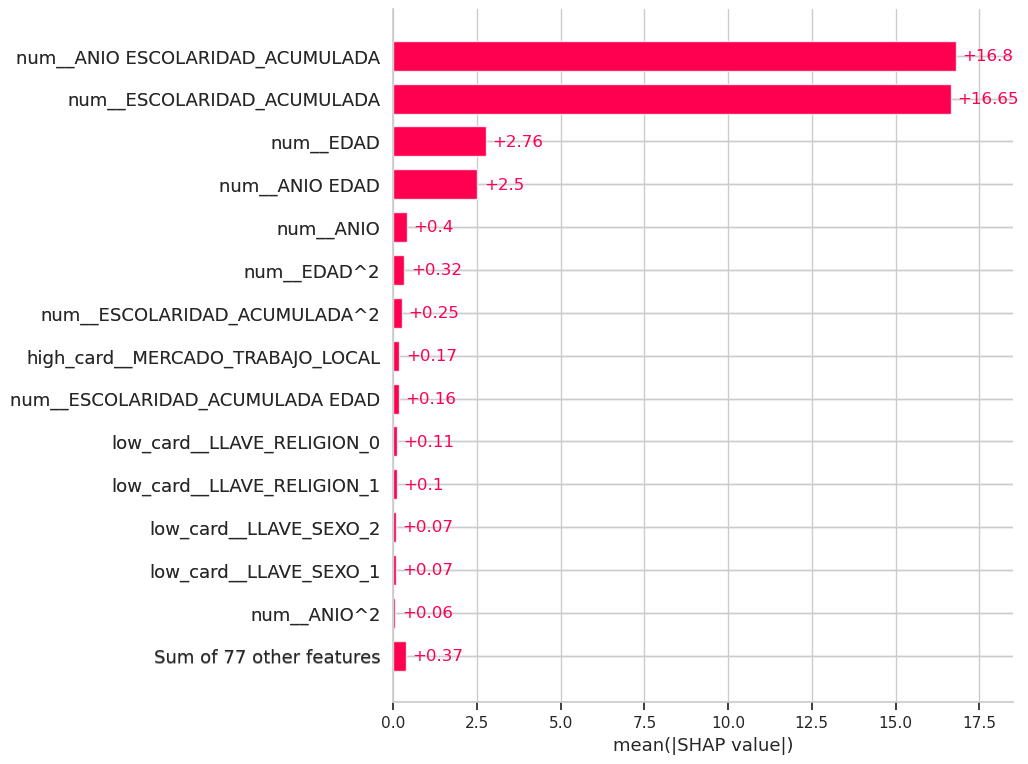

In [48]:
# ✅ Use the trained Ridge model for interpretation
model = ridge  # You can also switch to lasso here if needed

# 🧠 Initialize SHAP Explainer for linear models
# Uses model coefficients and data to compute feature contributions
explainer = shap.Explainer(model, X_train_prepared, feature_names=feature_names, algorithm="linear")

# 📉 Compute SHAP values for all training examples
shap_values = explainer(X_train_prepared)

# 📊 Visualize the most impactful features
# Beeswarm: Shows both magnitude and direction of impact for each feature
shap.plots.beeswarm(shap_values, max_display=15)

# 📊 Alternative: Bar plot showing mean absolute SHAP values
# Good for quick ranking of feature importance
shap.plots.bar(shap_values, max_display=15)

📊 Model 4: Random Forest Regressor

The Random Forest Regressor is a powerful and flexible machine learning algorithm used for predicting continuous outcomes. It belongs to the family of ensemble methods and is especially useful when:
- You suspect nonlinear relationships between features and the target
- You want robust performance without heavy assumptions about the data structure

🔍 How it works:
- A Random Forest builds multiple decision trees on random subsets of both the observations and the features.
- Each tree produces a prediction, and the final output is the average of all tree predictions.
- This averaging process reduces variance and guards against overfitting.



In [54]:
# 🌲 Instantiate a Random Forest Regressor
# We use 100 trees and a fixed random seed for reproducibility
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# 🔁 Perform 5-fold cross-validation using negative MSE as the scoring metric
# (scikit-learn returns negative values for loss functions, so we convert to positive)
rf_scores = cross_val_score(rf_model, X_train_prepared, y_train, cv=5, scoring='neg_mean_squared_error')
rf_mse = -rf_scores.mean()
rf_var = rf_scores.var()

# 🖨️ Report performance metrics
print(f"🌲 Random Forest MSE: {rf_mse:.4f}")
print(f"📉 Variance of MSE: {rf_var:.6f}")

# ✅ Fit the model on the entire training set
rf_model.fit(X_train_prepared, y_train)

🌲 Random Forest MSE: 0.5290
📉 Variance of MSE: 0.001770


RandomForestRegressor(random_state=42)

In [ ]:
# 🌟 Extract feature importances from the trained Random Forest model
importances = rf_model.feature_importances_
feature_names = full_pipeline.get_feature_names_out()

# 📋 Create a DataFrame linking feature names to their importance scores
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# 🔽 Sort the features by importance (descending order)
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# 🖨️ Display the top 15 most important features
print("📌 Top 15 most important features in Random Forest:")
print(importance_df.head(15))

                                  Feature  Importance
4         num__ANIO ESCOLARIDAD_ACUMULADA    0.231419
90       high_card__MERCADO_TRABAJO_LOCAL    0.223079
7         num__ESCOLARIDAD_ACUMULADA EDAD    0.094261
5                          num__ANIO EDAD    0.063676
3                             num__ANIO^2    0.039072
8                             num__EDAD^2    0.035846
2                               num__EDAD    0.035143
0                               num__ANIO    0.034419
79                 low_card__LLAVE_SEXO_2    0.018466
78                 low_card__LLAVE_SEXO_1    0.015911
88        low_card__LLAVE_SITUACONYUGAL_8    0.015544
81        low_card__LLAVE_SITUACONYUGAL_1    0.012930
6            num__ESCOLARIDAD_ACUMULADA^2    0.011118
23  low_card__LLAVE_TIETRASLADO_TRABAJO_7    0.010893
1              num__ESCOLARIDAD_ACUMULADA    0.010855


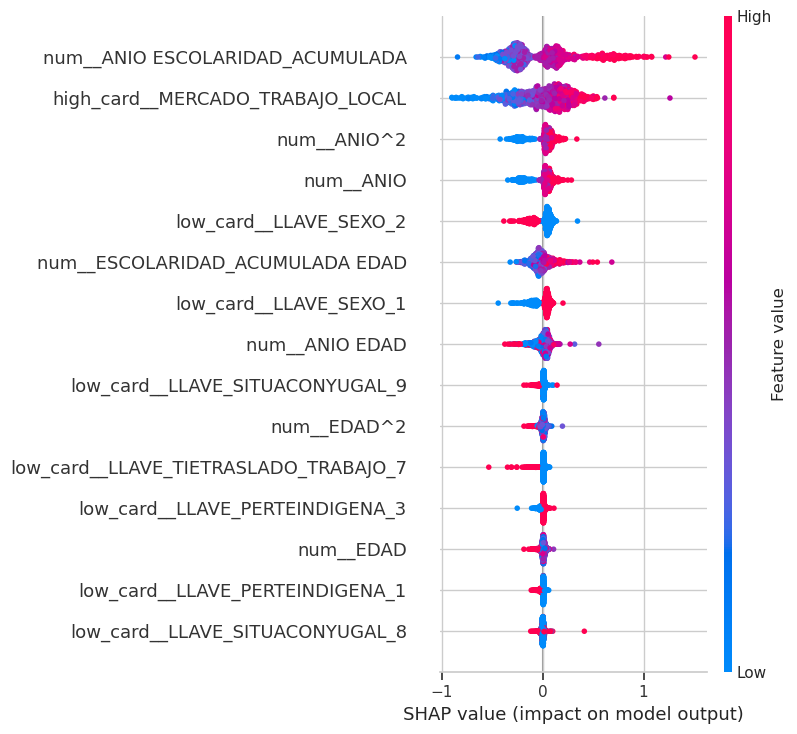

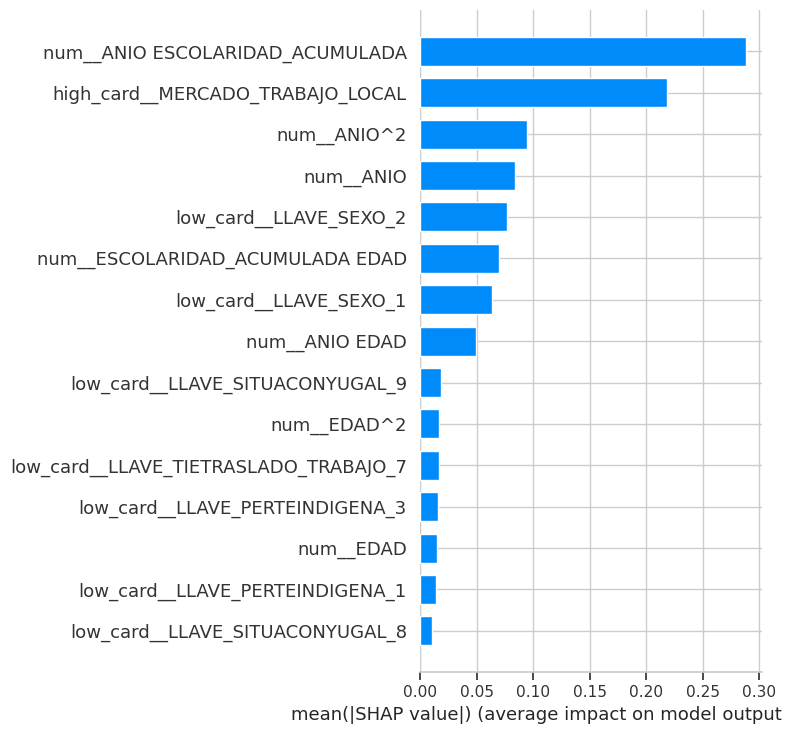

In [57]:
# ⚡ Use a representative sample (e.g., 1000 rows)
sample_idx = np.random.choice(X_train_prepared.shape[0], size=1000, replace=False)

# ✅ Ensure dense and numeric format
X_dense = X_train_prepared.toarray() if hasattr(X_train_prepared, "toarray") else X_train_prepared
X_sample = X_dense[sample_idx].astype(np.float64)  # Ensure float64 dtype

# 🧠 Create TreeExplainer
explainer = shap.TreeExplainer(rf_model)

# 🧮 Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# 🏷️ Feature names
feature_names = full_pipeline.get_feature_names_out()

# 🐝 Beeswarm plot
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, max_display=15)

# 📊 Bar plot (summary)
shap.summary_plot(shap_values, X_sample, feature_names=feature_names, plot_type="bar", max_display=15)


📊 Model 5: Gradient Boosting Regressor

Gradient Boosting is a powerful ensemble method that builds a strong predictive model by combining many weak learners—typically shallow decision trees. It improves performance by learning from the mistakes of previous trees in a sequential, focused way.

🔍 How it Works:
1. Builds Models Sequentially
	Instead of training one big model, Gradient Boosting trains a series of small trees—each new one focusing on the residuals (errors) of the last.
2.	Learns from Mistakes
	Each new tree is designed to correct the errors of the previous one. In essence, the model gradually learns what previous models got wrong.
3.	Focuses on the Hardest Cases
	By placing more weight on examples that are harder to predict correctly, the model pays attention to challenging patterns in the data.
4.	Combines Weak Learners into a Strong One
	The predictions from each tree are added together, producing a final model that is both accurate and robust.

In [58]:
# Instantiate model
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Cross-validation
gb_scores = cross_val_score(gb_model, X_train_prepared, y_train, cv=5, scoring='neg_mean_squared_error')
gb_mse = -gb_scores.mean()
gb_var = gb_scores.var()

print(f"🔥 Gradient Boosting MSE: {gb_mse:.4f}")
print(f"📉 Variance of MSE: {gb_var:.6f}")

# Fit full model
gb_model.fit(X_train_prepared, y_train)

🔥 Gradient Boosting MSE: 0.4800
📉 Variance of MSE: 0.001329


GradientBoostingRegressor(random_state=42)

In [59]:
# Get feature importances from the model
importances = gb_model.feature_importances_

# Get feature names from preprocessing pipeline
feature_names = full_pipeline.get_feature_names_out()

# Create DataFrame with importance
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# Sort by importance (descending)
importance_df_sorted = importance_df.sort_values(by="Importance", ascending=False)

# Display top features
print("📌 Top 15 most important features in Gradient Boosting:")
print(importance_df_sorted.head(15))



📌 Top 15 most important features in Gradient Boosting:
                                  Feature  Importance
4         num__ANIO ESCOLARIDAD_ACUMULADA    0.372061
90       high_card__MERCADO_TRABAJO_LOCAL    0.186485
7         num__ESCOLARIDAD_ACUMULADA EDAD    0.129677
3                             num__ANIO^2    0.083801
0                               num__ANIO    0.072947
78                 low_card__LLAVE_SEXO_1    0.036439
5                          num__ANIO EDAD    0.028511
79                 low_card__LLAVE_SEXO_2    0.028342
23  low_card__LLAVE_TIETRASLADO_TRABAJO_7    0.010986
12        low_card__LLAVE_PERTEINDIGENA_3    0.009345
2                               num__EDAD    0.008292
89        low_card__LLAVE_SITUACONYUGAL_9    0.007750
8                             num__EDAD^2    0.005324
16  low_card__LLAVE_TIETRASLADO_TRABAJO_0    0.004209
21  low_card__LLAVE_TIETRASLADO_TRABAJO_5    0.002117


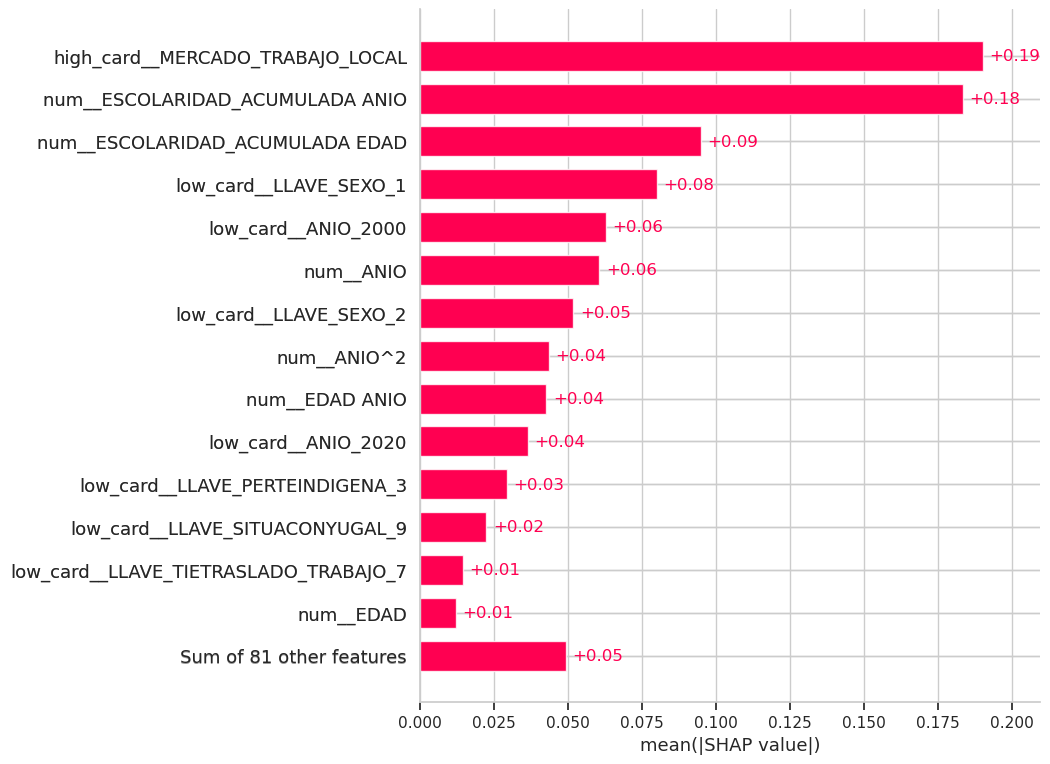

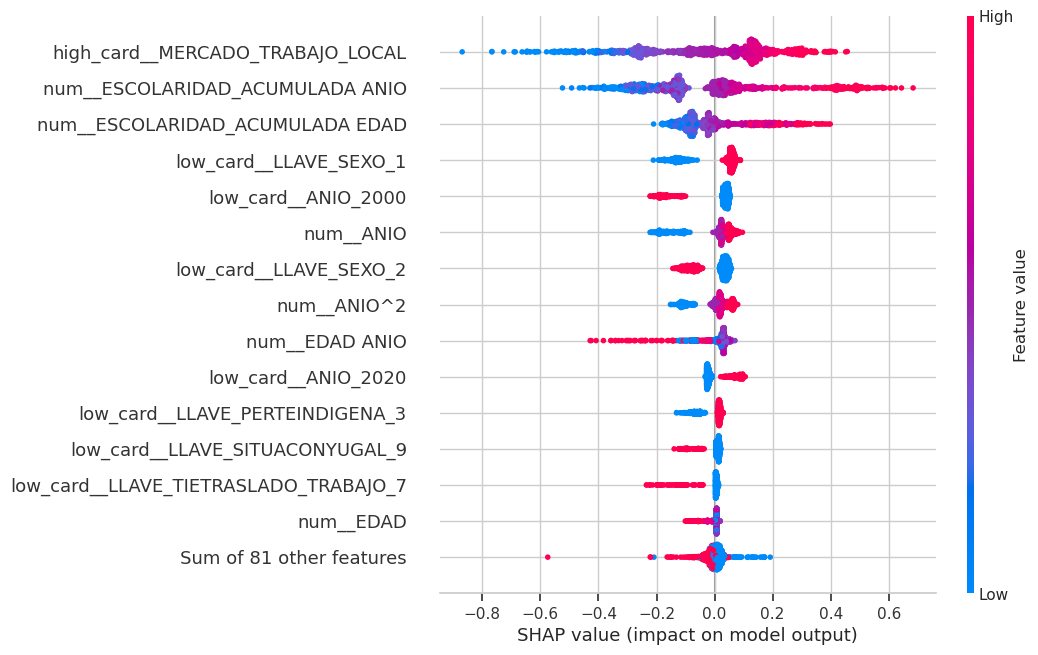

In [ ]:
# ⚡ Sample from the training data
sample_idx = np.random.choice(X_train_prepared.shape[0], size=1000, replace=False)
X_sample_sparse = X_train_prepared[sample_idx]

# 🔧 Convert sparse matrix to dense and ensure float format
X_sample = X_sample_sparse.toarray().astype(np.float64)

# 🧠 Create the SHAP explainer (with feature names)
explainer = shap.Explainer(gb_model, X_sample, feature_names=feature_names)

# 📊 Compute SHAP values
shap_values = explainer(X_sample)

# 🐝 SHAP beeswarm plot
shap.plots.beeswarm(shap_values, max_display=15)

# ✅ SHAP bar plot
shap.plots.bar(shap_values, max_display=15)

📊 Summary of Model Performance on Training Data

The following table summarizes the performance metrics (MSE, MAE, R²) for each model evaluated on the training dataset. These metrics provide insights into how well each model fits the data and captures the underlying patterns.
1. MSE (Mean Squared Error): Lower values indicate better fit.
2. MAE (Mean Absolute Error): Lower values indicate better fit.
3. R²: Higher values (closer to 1) indicate a better model fit, with 1 meaning perfect fit.

Here are the results for the models we have trained:

In [91]:
# Dictionary to store the results
results_train = {
    'Model': ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Random Forest', 'Gradient Boosting'],
    'MSE': [],
    'MAE': [],
    'R²': []
}

# List of fitted models
models = [lr_model, lasso, ridge, rf_model, gb_model]
model_names = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Random Forest', 'Gradient Boosting']

# Iterate through the models and calculate the metrics
for model in models:
    y_train_pred = model.predict(X_train_prepared)
    mse = mean_squared_error(y_train, y_train_pred)
    mae = mean_absolute_error(y_train, y_train_pred)
    r2 = r2_score(y_train, y_train_pred)
    
    # Append results to the dictionary
    results_train['MSE'].append(mse)
    results_train['MAE'].append(mae)
    results_train['R²'].append(r2)

# Create a DataFrame to display the results
results_df_train = pd.DataFrame(results_train)

# Print the results
print("Training Data Model Evaluation Metrics:")
print(results_df_train)

Training Data Model Evaluation Metrics:
               Model    MSE    MAE     R²
0  Linear Regression 0.4803 0.4874 0.4262
1   Lasso Regression 0.4873 0.4924 0.4179
2   Ridge Regression 0.4806 0.4877 0.4260
3      Random Forest 0.0771 0.1946 0.9078
4  Gradient Boosting 0.4565 0.4752 0.4547


## Final Step: Test All Models on the Test Data

After evaluating and tuning the models on the training set, it’s crucial to assess their performance on unseen data (the test set). This ensures that the models generalize well to new data and that we are not overfitting to the training data.

In this step, we will test all the models (Linear Regression, Lasso, Ridge, Random Forest, and Gradient Boosting) on the test set and evaluate their performance using the following metrics:
1. Mean Squared Error (MSE): Measures the average of the squares of the errors, which tells us how well our model is fitting the data.
2. Mean Absolute Error (MAE): Measures the average of the absolute errors, giving us an idea of how far off predictions are from actual values.
3. R² (Coefficient of Determination): Indicates the proportion of the variance in the dependent variable that is predictable from the independent variables.

By comparing these metrics across models, we can identify which model performs the best on unseen data.

✅ Step 1: Prepare the Test Data

In [78]:
# Preprocess the test set using the already fitted pipeline
X_test_prepared = full_pipeline.transform(X_test)

✅ Step 2: Evaluate All Models on the Test Set

In [86]:
# Make predictions
y_pred_linear = lr_model.predict(X_test_prepared)
y_pred_lasso = lasso.predict(X_test_prepared)
y_pred_ridge = ridge.predict(X_test_prepared)
y_pred_rf = rf_model.predict(X_test_prepared)
y_pred_gb = gb_model.predict(X_test_prepared)

# Store results in a list of dictionaries
results = [
    {
        'Model': 'Linear Regression',
        'MSE': mean_squared_error(y_test, y_pred_linear),
        'MAE': mean_absolute_error(y_test, y_pred_linear),
        'R²': r2_score(y_test, y_pred_linear)
    },
    {
        'Model': 'Lasso Regression',
        'MSE': mean_squared_error(y_test, y_pred_lasso),
        'MAE': mean_absolute_error(y_test, y_pred_lasso),
        'R²': r2_score(y_test, y_pred_lasso)
    },
    {
        'Model': 'Ridge Regression',
        'MSE': mean_squared_error(y_test, y_pred_ridge),
        'MAE': mean_absolute_error(y_test, y_pred_ridge),
        'R²': r2_score(y_test, y_pred_ridge)
    },
    {
        'Model': 'Random Forest',
        'MSE': mean_squared_error(y_test, y_pred_rf),
        'MAE': mean_absolute_error(y_test, y_pred_rf),
        'R²': r2_score(y_test, y_pred_rf)
    },
    {
        'Model': 'Gradient Boosting',
        'MSE': mean_squared_error(y_test, y_pred_gb),
        'MAE': mean_absolute_error(y_test, y_pred_gb),
        'R²': r2_score(y_test, y_pred_gb)
    }
]

✅ Step 3: Compare the Results

In [92]:
# Create and display DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by="MSE")

# Print final comparison without rounding
print("Final Model Evaluation Metrics:")
print(results_df)

Final Model Evaluation Metrics:
               Model    MSE    MAE     R²
0  Linear Regression 0.5035 0.5027 0.4095
2   Ridge Regression 0.5038 0.5029 0.4092
1   Lasso Regression 0.5095 0.5043 0.4025
4  Gradient Boosting 0.5098 0.5046 0.4021
3      Random Forest 0.5449 0.5317 0.3609
